In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

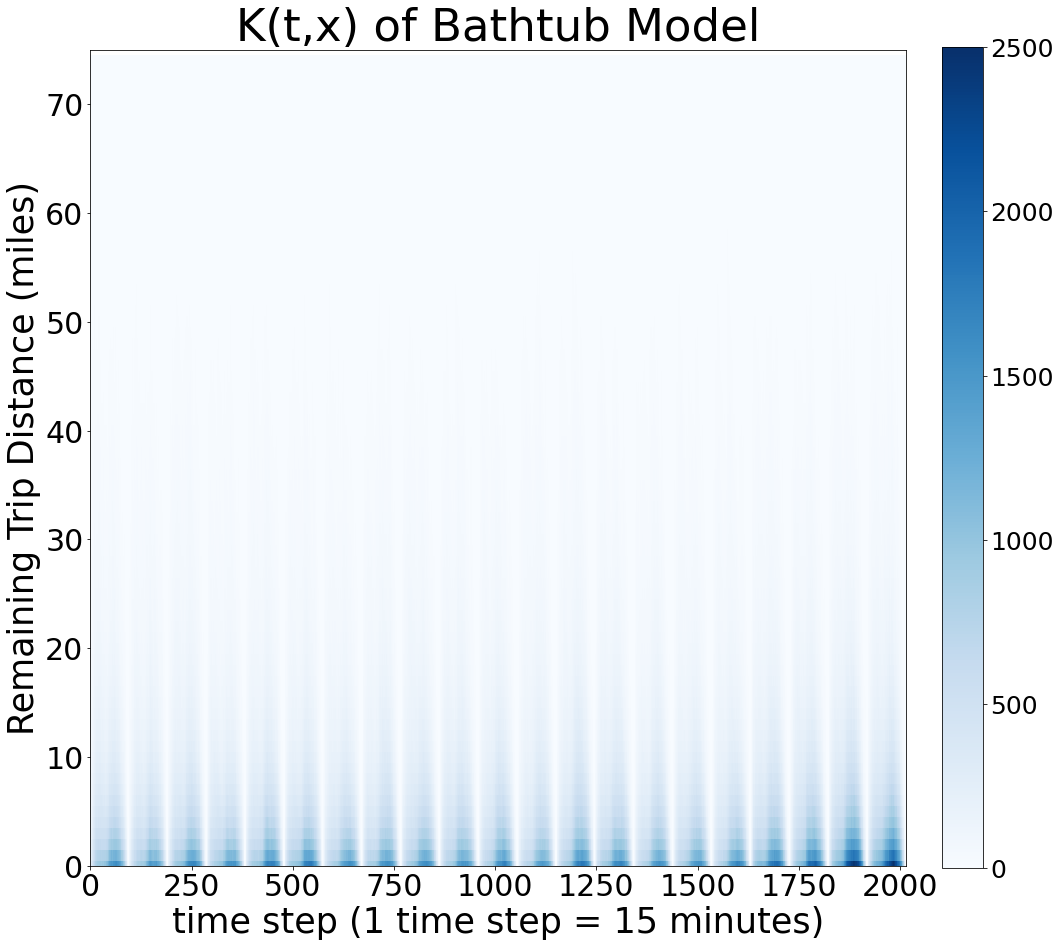

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 25 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  3024
N_u =  604
N_f =  1208


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(604, 2)

In [12]:
X_u_test.shape

(2420, 2)

In [13]:
X_u_train

array([[0.67567568, 0.52406948],
       [0.        , 0.08436725],
       [0.        , 0.35334988],
       ...,
       [0.        , 0.35831266],
       [0.        , 0.79801489],
       [0.67567568, 0.11215881]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.023339662451924197 0.043876349823995978 0.0028029750798524151 0.7503500252729127
0.022130279423884475 0.042605090690743162 0.0016554681570257869 0.7423644323612619
0.019252654508997491 0.037738736889615161 0.00076657212837981793 0.707296271771453
0.016242743989036027 0.03086934981835348 0.0016161381597185724 0.6492045792522416
0.013271176286554139 0.023406036638894307 0.0031363159342139703 0.5749492282495231
0.013155087410323445 0.023182073858533863 0.0031281009621130259 0.5714055476761433
0.013012570006642432 0.023060594593760003 0.0029645454195248622 0.5687464545371994
0.012785772675449338 0.02300273934135514 0.0025688060095435347 0.5668474227302159
0.0124017270073718 0.02284127640808303 0.0019621776066605714 0.5642822732386552
0.0119333914096274 0.022102775963833702 0.0017640068554210962 0.5574487358278298
0.011682330167741594 0.021646053671602727 0.0017186066638804627 0.5550463581743342
0.011617257285798198 0.021546703918027803 0.0016878106535685939 0.555114778114986
0.0115024542

0.0073853890630960883 0.013241044368685397 0.0015297337575067797 0.4461541339251241
0.0073807758401801139 0.01323867997891226 0.0015228717014479679 0.4459773022435822
0.0073762307549722992 0.013237722159344019 0.0015147393506005789 0.4459267038295732
0.0073688572275766757 0.013218333262002583 0.0015193811931507675 0.44579280593081005
0.0073638295676480637 0.013168932701442891 0.0015587264338532358 0.4453136331971428
0.0073631068197363876 0.013177548676875067 0.0015486649625977076 0.44540856860761574
0.0073626085069031936 0.013183016819205187 0.0015422001946012 0.44545225541291544
0.0073622313923491639 0.013191986718862922 0.0015324760658354071 0.4455908852074594
0.0073617330329342912 0.01319417379761877 0.0015292922682498137 0.44562335016707477
0.007360371146387967 0.013200022171456381 0.0015207201213195522 0.4456253194768756
0.0073595579144768919 0.013193922355608774 0.0015251934733450105 0.4456509955247566
0.0073576515539943779 0.013178715800603485 0.00153658730738527 0.4453662211230

0.0072523988298279062 0.013011536627421766 0.0014932610322340456 0.443553306120814
0.0072515561300794231 0.0130128996522694 0.0014902126078894466 0.4435974647570095
0.0072506903984832539 0.013010567847386967 0.0014908129495795402 0.4435429308261501
0.0072497479253767014 0.013005015352717531 0.0014944804980358732 0.44350866932193694
0.0072480877092938028 0.012997667788054328 0.0014985076305332778 0.44333434044733705
0.0072454393685908447 0.012985439232004022 0.0015054395051776685 0.44344631496042747
0.0072431491556008473 0.012995974061587822 0.001490324249613872 0.4435389826224483
0.0072418120968535784 0.013008563665633672 0.0014750605280734841 0.44382535514101995
0.007241026480326854 0.013010337963296455 0.001471714997357253 0.4437475504636474
0.0072401229545858981 0.012997012665579781 0.0014832332435920157 0.4437042953227401
0.0072392582409257647 0.012989874922999687 0.0014886415588518422 0.44361005465821934
0.0072377843025031325 0.012973839457779003 0.0015017291472272625 0.4434315568

0.0071935323202686864 0.012864169569597904 0.0015228950709394689 0.44391900006880886
0.0071933016377891991 0.012862283956626955 0.0015243193189514426 0.44392013789977736
0.0071930160641982283 0.012862143917483 0.001523888210913457 0.4439218661910912
0.0071926624061058424 0.012861508543364455 0.0015238162688472302 0.44401393974188663
0.007192389076970898 0.012866530627671804 0.0015182475262699915 0.44402713905245583
0.0071921560100107968 0.012865836506782215 0.0015184755132393777 0.44405895520025074
0.0071917947740520044 0.01286423808333469 0.001519351464769318 0.44403811402943894
0.0071913731819074527 0.012864780338776504 0.0015179660250384005 0.4439612973991903
0.00719115865758363 0.012864915069305162 0.0015174022458620997 0.44401068758081713
0.0071909307857640414 0.012862069994699719 0.0015197915768283645 0.44391948055360797
0.0071907488025332424 0.012863508634528646 0.0015179889705378396 0.4439234509795004
0.0071906817634503272 0.01286522447631455 0.0015161390505861046 0.44400764954

0.0071738953789127332 0.012844313205020146 0.0015034775528053204 0.4434513918489538
0.0071733968819936086 0.012839785364489396 0.0015070083994978205 0.44355523082269294
0.00717291694371566 0.01284331999334629 0.0015025138940850298 0.4436672941381808
0.0071722933198137681 0.01283757729194032 0.0015070093476872159 0.4435670576457481
0.0071720792832773144 0.012839136725528912 0.0015050218410257174 0.4434752926409527
0.0071719717722094059 0.012837071120825641 0.0015068724235931697 0.44352656781193794
0.0071718905211436415 0.01283801582574373 0.0015057652165435527 0.44357306525137435
0.007171802030297058 0.012835419541695392 0.0015081845188987244 0.44347675139846593
0.007171692271227624 0.012835238287862101 0.0015081462545931477 0.4435280945824631
0.0071715164639431332 0.012834943251029707 0.0015080896768565593 0.44351031916710004
0.0071710255554793823 0.012834086739533733 0.0015079643714250312 0.4435369041323923
0.0071704918515077161 0.012841800881601506 0.0014991828214139258 0.44352772930

0.0070812023009207258 0.012800776825768061 0.0013616277760733905 0.4427857694372595
0.0070803218540812377 0.012796600607365803 0.0013640431007966719 0.4426457724475074
0.0070790826670019021 0.01279733547005368 0.0013608298639501233 0.44276629340773654
0.0070779277246813353 0.012793578931359679 0.0013622765180029927 0.44302953293713626
0.0070765223857217384 0.012793445798730841 0.0013595989727126358 0.4429340224412887
0.0070748796333897669 0.012791180592786583 0.0013585786739929516 0.44280501247767734
0.0070731263914569084 0.01278581511046578 0.0013604376724480373 0.4427486216054925
0.007071796713822848 0.012783896528110617 0.0013596968995350791 0.4426584667388463
0.007068444909596178 0.012783296885354107 0.0013535929338382483 0.4426353721410349
0.0070669515745973369 0.012771054554619079 0.0013628485945755954 0.44243057053959445
0.007066477870012273 0.012763041976656711 0.0013699137633678344 0.4421179805936153
0.00706568653087709 0.012772007862185365 0.0013593651995688163 0.442288383279

0.00704163343205721 0.012715556116625641 0.0013677107474887795 0.441880746562771
0.0070414770213749634 0.012713152229784912 0.0013698018129650149 0.44187825147860643
0.0070412996510122831 0.012718291542726438 0.0013643077592981276 0.44191064815858605
0.007041197306768208 0.012714877455310225 0.0013675171582261914 0.4418457179978458
0.0070411056572131456 0.012709728567321497 0.0013724827471047951 0.44195662881299047
0.00704099100662776 0.012714361647607888 0.0013676203656476313 0.4418988945457087
0.007040902526787296 0.012715496726863533 0.0013663083267110594 0.4418959608219544
0.0070407322103272947 0.012715756748836939 0.0013657076718176513 0.4418788426402019
0.0070403127303581446 0.012722070193200145 0.0013585552675161438 0.4419467004027438
0.00704007653137409 0.012717233014317876 0.0013629200484303024 0.44175443582428614
0.0070394564752158514 0.012726808513378454 0.00135210443705325 0.4419582997692639
0.0070391103109080757 0.012729234280993568 0.0013489863408225832 0.4420423471503468

0.0070035375644394316 0.012708234069505855 0.0012988410593730085 0.4414856293593554
0.007003193618796066 0.012713434445649338 0.001292952791942795 0.4415249698963469
0.0070029025654173172 0.012719796396789662 0.0012860087340449728 0.4415623232569344
0.007002433686706052 0.012721934513222842 0.0012829328601892626 0.44157256071312445
0.007001974553091728 0.012721486782360146 0.0012824623238233105 0.44168171036801024
0.0070011758517689766 0.012723485357403462 0.0012788663461344902 0.4417045012087688
0.0070001894427943493 0.012715143770039537 0.0012852351155491612 0.44164884444068236
0.0069993951544915205 0.012717498475952197 0.0012812918330308435 0.44176180517467273
0.0069990579886551364 0.012715773359155984 0.0012823426181542881 0.4417179668508619
0.0069986138127096087 0.012707342048800085 0.0012898855766191326 0.44159312472118667
0.0069975968101033134 0.012707030894696115 0.0012881627255105115 0.44168488101755793
0.0069958649346835156 0.012717392157292551 0.0012743377120744788 0.4418655

0.0068750181292339891 0.012651282238274848 0.001098754020193131 0.4409845575382165
0.0068739182810955589 0.01264541481040707 0.001102421751784047 0.4408452497268741
0.006872679932779643 0.012649060823427021 0.0010962990421322645 0.441082011288364
0.0068715860836498638 0.012634115522177074 0.0011090566451226532 0.44087274651989655
0.0068707801998427976 0.012623852573353913 0.0011177078263316822 0.4404090224523011
0.0068694206517568215 0.012629054307232958 0.0011097869962806842 0.44062825328357347
0.0068684437036104044 0.012635174462458404 0.0011017129447624041 0.4408269915673775
0.0068668827747168032 0.012644512817835006 0.0010892527315986002 0.4408531747547931
0.0068658698017012533 0.012634360571862964 0.0010973790315395424 0.4409219105413999
0.0068647914520150108 0.012643732045026213 0.0010858508590038084 0.4409335467785784
0.00686392258953398 0.01263666175026429 0.0010911834288036706 0.44102958153727645
0.0068632544111884644 0.012621970116939076 0.001104538705437852 0.440741352098447

0.0067762597317937616 0.012423249653461093 0.0011292698101264302 0.43800359256264826
0.006775140829904938 0.012425044411052064 0.0011252372487578124 0.4382543900490669
0.006774106876345617 0.01241968183495526 0.0011285319177359748 0.438149991340879
0.0067730968159934258 0.012416924049928928 0.0011292695820579231 0.43816406352599585
0.0067723951410008738 0.012420195083876614 0.0011245951981251328 0.4381906951756865
0.0067717109585995324 0.0124194598214772 0.0011239620957218652 0.4382963471941834
0.0067710184636677485 0.012424631862776241 0.0011174050645592548 0.4382516904853226
0.0067703169139093581 0.012428478403763044 0.0011121554240556722 0.43827395423016535
0.0067693742682406561 0.012428768469956112 0.0011099800665252 0.4382970216760805
0.0067682912276804683 0.012425255156311035 0.001111327299049901 0.438155849524879
0.0067663960015931258 0.012415378847596234 0.0011174131555900168 0.4380332071549546
0.00676492017640641 0.012417372470775179 0.0011124678820376413 0.4380269005460866
0.

0.0066987319939956023 0.012375642801517029 0.0010218211864741755 0.43792161830180065
0.0066984558287475626 0.012371047088322054 0.0010258645691730711 0.4379282600777595
0.0066980641415556779 0.012372475422003345 0.001023652861108011 0.437957108020535
0.006697650813152713 0.012373087270756278 0.0010222143555491474 0.43799033846309465
0.0066974000618610615 0.012375249970862189 0.0010195501528599347 0.43807702902515855
0.0066970824812006375 0.012375957649458891 0.001018207312942384 0.43814724362195506
0.0066967456835584117 0.012381187402731794 0.0010123039643850297 0.4381871216170069
0.0066964648998355273 0.01238106928080215 0.0010118605188689043 0.43823132905465645
0.0066960981457023609 0.012381355065976218 0.0010108412254285033 0.43817046933629905
0.0066954812663141683 0.012380903146950072 0.0010100593856782647 0.43808707472833375
0.0066949766934687608 0.012382720247676582 0.0010072331392609395 0.43800496799987115
0.00669422923147685 0.012375786972580934 0.0010126714903727671 0.43792686

0.0065901248415372194 0.012383855508199097 0.00079639417487534214 0.43777776551253805
0.0065889156414087463 0.01238258889630359 0.00079524238651390317 0.4377552468168841
0.0065874227351982069 0.012380465534842627 0.00079437993555378766 0.43767271825169396
0.0065859201398412934 0.012378968895950746 0.00079287138373184 0.4376701470733388
0.006584838730248347 0.012367230502382559 0.00080244695811413443 0.43763302818238936
0.0065827619124638435 0.012371685127549882 0.000793838697377804 0.43770139454595547
0.0065818429111634677 0.012376783270814254 0.00078690255151268255 0.43774362953622636
0.0065805004593620514 0.012366151524719539 0.00079484939400456447 0.43777853446948894
0.0065786641368389175 0.01235956262657174 0.00079776564710609568 0.4378681294906794
0.0065772743570242089 0.012358500212443668 0.00079604850160474986 0.43779139679701845
0.00657603710174917 0.012358987656137859 0.00079308654736048043 0.43773852154240284
0.0065747516873204195 0.012370187503715961 0.00077931587092487783 0

0.0064141107247802391 0.012367298018399114 0.0004609234311613645 0.4370695499403396
0.0064113639485451719 0.012372225123537703 0.00045050277355264086 0.4370068792995855
0.0064090824738191722 0.012370938632453999 0.00044722631518434613 0.43745141794766496
0.0064062732276534374 0.012350648538411613 0.00046189791689526204 0.43716046501667843
0.0064030409115187256 0.012361936124682896 0.00044414569835455546 0.4372390732967711
0.0064003464471334755 0.0123677573781956 0.00043293551607135092 0.4373650317713844
0.0063977341719176619 0.012365828583701052 0.00042963976013427307 0.4373798472213569
0.0063964062148011355 0.012364332472476007 0.00042847995712626486 0.4377617687968489
0.0063940563142337817 0.012358827523015391 0.0004292851054521725 0.437782703405258
0.0063907059128262209 0.012362431156646597 0.00041898066900584563 0.43737320518830763
0.0063871549197351855 0.012371730993121655 0.00040257884634871627 0.43741615471511835
0.0063834651713356085 0.012379308713787866 0.00038762162888335164 

0.0063368681714471454 0.01229934000208591 0.00037439634080838063 0.43720243713018264
0.0063362498428045332 0.0122995614850293 0.00037293820057976678 0.4372315591443475
0.0063354845936298716 0.012300182255746082 0.00037078693151366087 0.4372830933127647
0.0063348832894722911 0.012300451328653284 0.00036931525029129891 0.4373261914129856
0.006334662556803536 0.012301844404668661 0.00036748070893841215 0.43731172787347344
0.0063345434425534659 0.012302528845587043 0.00036655803951988862 0.4372945698409413
0.0063344480347724648 0.012300873575207394 0.00036802249433753555 0.4373013283926633
0.0063343433631111532 0.012301429530090769 0.00036725719613153805 0.43731341569004584
0.0063342198253207981 0.01229970567719175 0.00036873397344984579 0.4372527030184565
0.0063340778512351592 0.012297656974206072 0.00037049872826424554 0.4372430835754323
0.0063339407113607079 0.012291843639147452 0.00037603778357396371 0.43721031221761153
0.0063337817542707129 0.01229222916526475 0.00037533434327667576 0

0.0063082612090204051 0.012273367668842667 0.000343154749198143 0.4369130358042677
0.0063080519621066117 0.012273827632208517 0.00034227629200470576 0.4368876013289751
0.0063078922771515576 0.01227322008964783 0.00034256446465528426 0.43693800480335143
0.0063077546264953136 0.01227396554345781 0.00034154370953281817 0.4369310098617488
0.0063076368180140681 0.012276071612261002 0.000339202023767135 0.43695319283262557
0.0063074956453317253 0.012274751199803672 0.00034024009085977875 0.43692225546004754
0.0063074255769218508 0.012274131414825086 0.00034071973901861439 0.43692009211125504
0.0063071740974798944 0.012270854921877948 0.0003434932730818398 0.43692676966280225
0.0063070267242408447 0.012271001383865865 0.00034305206461582538 0.4369174938493293
0.0063068342244312773 0.012273000885480475 0.00034066756338207933 0.4369510786418805
0.0063067817091538511 0.012272915048036513 0.00034064837027118891 0.4368832748042792
0.0063067071674114926 0.012272622585732158 0.00034079174909082833 0

0.0062965848699838012 0.012261147472969502 0.00033202226699810073 0.43666671932561996
0.0062964627796930047 0.012259239938994127 0.00033368562039188279 0.43662568415960723
0.006296327254847172 0.012256867799981017 0.00033578670971332785 0.4365753258400361
0.0062962205509830777 0.012255409648100433 0.0003370314538657223 0.4365568465580921
0.0062960658077700349 0.012254850542864239 0.00033728107267583067 0.43656641985265204
0.0062959025863759434 0.012253816444137453 0.00033798872861443306 0.4365591175196958
0.0062956297122095106 0.012253967118182954 0.00033729230623606807 0.4365921348008033
0.0062953747967567485 0.012254361445080511 0.00033638814843298581 0.4366391829330319
0.0062952233121060857 0.012250703444379117 0.00033974317983305442 0.43662760446087173
0.0062950949815799313 0.012250098431314176 0.00034009153184568641 0.4365759411792546
0.0062945969740391579 0.012252031864435433 0.00033716208364288354 0.4365819966931611
0.0062943027102403482 0.012249043755357635 0.000339561665123061

0.0062800942582579081 0.012195610632245099 0.00036457788427071767 0.43663508709439086
0.0062799515459571031 0.012193549323695978 0.00036635376821822908 0.43662683117283013
0.006279848581749391 0.012190982872351132 0.00036871429114764968 0.4365696437950467
0.00627974320708347 0.01219100402272345 0.00036848239144348949 0.4365708090132943
0.00627968784136282 0.012192446185622759 0.00036692949710287974 0.43656577761025805
0.0062796299676485959 0.01219291637637932 0.00036634355891787182 0.4365710267766078
0.00627954817338074 0.012192894178784748 0.00036620216797673066 0.43658666323844236
0.0062794645798986172 0.012192602281396072 0.00036632687840116278 0.4365819755429271
0.0062793717486619759 0.012193169863661084 0.00036557363366286817 0.43663006954428496
0.006279295975581565 0.012194413963007132 0.00036417798815599744 0.4365967258571051
0.0062792214954883255 0.01219464515670607 0.00036379783427058 0.4366139595198924
0.006279112738413797 0.012195031025307551 0.00036319445152004185 0.4366362

0.0062610785100824847 0.012147813246225606 0.00037434377393936384 0.43590336259517326
0.0062607191769119604 0.012147185120245601 0.00037425323357832011 0.4359425853027869
0.0062603447775488258 0.012144336393155082 0.00037635316194256966 0.43593289240587635
0.0062600568047176119 0.0121427095344134 0.00037740407502182319 0.43589835483653117
0.0062597354607886275 0.012139140099990132 0.00038033082158712246 0.4358511503276063
0.0062594864801372935 0.012140548201882694 0.00037842475839189375 0.4358595369718265
0.0062592106267302591 0.012139422169874141 0.00037899908358637673 0.4358692967095624
0.0062590234182501739 0.012137461223675714 0.0003805856128246348 0.43589362467651704
0.0062587637112853055 0.012136578769110487 0.0003809486534601227 0.43592104277625693
0.0062584743409540141 0.012137655616657269 0.00037929306525075966 0.43592275850364853
0.0062581481223297642 0.01213626927587508 0.00038002696878444876 0.43586930105209115
0.0062578913659187361 0.0121340213566549 0.00038176137518257185

0.0062445469808937041 0.012114893820696882 0.00037420014109052673 0.4358964872219191
0.00624426670813716 0.012115444737181406 0.00037308867909291416 0.4358314364777908
0.0062438833532413229 0.012115897935539872 0.00037186877094277443 0.435891784383629
0.0062435074481463444 0.012111409268792176 0.00037560562750051292 0.43600558736958894
0.0062432139507984921 0.012111539607916933 0.00037488829368005145 0.4360097984734425
0.0062429838376483904 0.012111341344163791 0.00037462633113299009 0.4358906035836374
0.0062428122404997932 0.012108909709273162 0.00037671477172642359 0.4358918177005874
0.0062427080743521178 0.012108961332401254 0.000376454816302982 0.4359005683873265
0.0062426138037092434 0.012108831836253628 0.00037639577116486 0.4359048271104164
0.0062425268179743957 0.012107535229238686 0.0003775184067101054 0.4358943226611522
0.0062424941459383468 0.012108370526845328 0.00037661776503136583 0.4358985129995702
0.00624243736430655 0.01210783544215518 0.00037703928645792083 0.43588605

0.0062328657503709856 0.012079356441076879 0.00038637505966509134 0.43567147640378806
0.0062327144878169694 0.012079516513026455 0.00038591246260748403 0.4356345038937054
0.0062326400482010189 0.012082261816676383 0.00038301827972565469 0.43567227522416013
0.0062325687795483911 0.012082492323151922 0.0003826452359448595 0.43568589066327945
0.0062324725405085747 0.01208081063677386 0.00038413444424328837 0.4357005441187189
0.0062323940489980882 0.012079712553054569 0.00038507554494160852 0.43569459063282445
0.0062322939171611394 0.012078230213265794 0.00038635762105648514 0.43570902259679173
0.00623209908120915 0.012076571874001157 0.00038762628841714235 0.435710088967345
0.0062319855316922178 0.012076235023099928 0.00038773604028450735 0.43570671343594664
0.00623181121522846 0.012076882332614497 0.00038674009784242421 0.4356762587448623
0.0062317856027892171 0.012077411775976564 0.00038615942960187037 0.4356733803814608
0.0062316435776147592 0.012079255410370481 0.00038403174485903785 

0.0062191735260790507 0.012025414817990432 0.00041293223416766944 0.4356251377590927
0.0062190582434259794 0.012024454944226184 0.00041366154262577494 0.43560816070151376
0.0062189382882310192 0.012023364302937036 0.00041451227352500247 0.43559987445602205
0.0062188896225068742 0.01202315681073556 0.00041462243427818786 0.43559015101459336
0.0062188376250923117 0.012023394287761309 0.00041428096242331481 0.43559191951277226
0.0062187983830860813 0.012023858041108983 0.00041373872506318048 0.4356062930715953
0.0062187518836687968 0.012024226106308036 0.00041327766102955768 0.4356069613886993
0.0062186956635925175 0.012024727049490739 0.00041266427769429646 0.43562752945651595
0.00621866659974564 0.012025112020837855 0.00041222117865342462 0.4356369467458123
0.0062186198296746258 0.012025327042412881 0.00041191261693637022 0.4356374081478276
0.0062185597332292553 0.012025286483597851 0.0004118329828606608 0.43563461827603395
0.0062184991076619069 0.012026225843504103 0.000410772371819711

0.0062120275195783857 0.012031619842511727 0.00039243519664504487 0.4356453362687751
0.0062120064600147632 0.012030793853257398 0.00039321906677212759 0.43564067846868487
0.0062119765552561771 0.012030511498091177 0.00039344161242117819 0.4356451539131073
0.0062119473350301354 0.01203002655630107 0.00039386811375920054 0.4356467267781483
0.00621191800990879 0.012029699164544628 0.00039413685527295268 0.43564572167000615
0.006211895832946096 0.012029267306580991 0.0003945243593112 0.4356451049905049
0.006211866979235604 0.012029234232006266 0.00039449972646494216 0.4356347076597965
0.0062118299452067335 0.012028749442578101 0.00039491044783536655 0.4356293806042276
0.0062117911764102036 0.012028917114915752 0.00039466523790465511 0.43562484195005263
0.00621173444402653 0.012027896349630633 0.00039557253842242721 0.43561811938096173
0.00621167470188142 0.012027470111172221 0.00039587929259061794 0.4356299592013687
0.006211665271362324 0.012026636910073156 0.00039669363265149157 0.4356229

0.0062024950633226619 0.012038721884072314 0.00036626824257301061 0.4355891387547964
0.0062021298992948051 0.012036599869600107 0.00036765992898950305 0.43562091918139767
0.00620165066564643 0.012034777540763441 0.00036852379052941878 0.43565704944434064
0.00620132610922583 0.012037425013692919 0.00036522720475873978 0.4356301294476906
0.0062010914246590438 0.012039938902719545 0.00036224394659854179 0.4356134732126204
0.0062010000549899231 0.012041213755893237 0.00036078635408660974 0.4356095218559049
0.0062008533178771119 0.012042629105247721 0.00035907753050650284 0.43557713042957513
0.0062007026006079893 0.012043086563967687 0.000358318637248292 0.43555938168312597
0.0062004889622427469 0.012042026246251836 0.00035895167823365862 0.43555854220070717
0.006200141225094556 0.012042671832319688 0.00035761061786942409 0.43552414807646933
0.006199559656691331 0.012042613151906469 0.000356506161476193 0.4354905567615988
0.0061994045920888254 0.012041526593914909 0.00035728259026274114 0.4

0.00618362705327903 0.012003407332229016 0.00036384677432904411 0.43558997426846724
0.0061835955953457008 0.012003551923773325 0.00036363926691807729 0.4356033530967447
0.0061835457019730729 0.01200363577423301 0.00036345562971313585 0.4355994185151686
0.0061834734116178545 0.01200347279900774 0.00036347402422796975 0.4355954519171681
0.00618340776202752 0.012003542077542746 0.00036327344651229573 0.435594212498015
0.0061833691732206021 0.012003061922243298 0.00036367642419790559 0.43558831608836157
0.0061833154078137151 0.012002200709222206 0.00036443010640522448 0.43560654199086557
0.0061831987304568382 0.012001503080350716 0.00036489438056295988 0.43561129353756567
0.0061830862459401233 0.01200102925106857 0.00036514324081167622 0.435589464208941
0.0061829719018512089 0.012001071834894142 0.00036487196880827515 0.43556237249955787
0.0061829218636881922 0.012000761010308494 0.00036508271706788974 0.4355641795568711
0.0061828526640124492 0.01200048468979951 0.0003652206382253888 0.435

0.0061700399856049288 0.011977100647803071 0.00036297932340678625 0.4354801980606276
0.0061699599677908085 0.011975765443037394 0.00036415449254422204 0.43547413264343976
0.0061699477046663811 0.011975439724610154 0.00036445568472260811 0.43545326876556917
0.0061698805893458941 0.011976503744535462 0.00036325743415632658 0.435473683750028
0.0061698505372800617 0.01197739953826865 0.00036230153629147394 0.43548240590499043
0.0061698105726334706 0.01197796134668668 0.00036165979858026177 0.43549036214075587
0.0061697481642234292 0.011978174718678193 0.00036132160976866634 0.43552067119326604
0.0061697067177914492 0.011977928433722343 0.00036148500186055586 0.43553945951050804
0.0061696463041612023 0.0119782013300999 0.00036109127822250495 0.43552965466179394
0.0061695784888225495 0.011977842060922748 0.00036131491672234989 0.4355308332606298
0.0061695234294769363 0.011977988679554949 0.000361058179398924 0.4355174698723303
0.0061695049666257084 0.011978018033695555 0.00036099189955586135

0.0061615147699795713 0.011964000704270486 0.00035902883568865679 0.43538383940598924
0.0061614358738313665 0.011963932785481277 0.00035893896218145539 0.4353797392910946
0.0061613760961394138 0.011962816993274727 0.00035993519900410072 0.43537534751233553
0.0061613045792832527 0.011962489724803698 0.00036011943376280839 0.4353949903753708
0.0061612274508761888 0.011962144420788511 0.000360310480963867 0.435407415296907
0.0061611188265705457 0.011960768796323882 0.00036146885681720924 0.4354163909209655
0.0061610644976236636 0.011958477327570625 0.00036365166767670222 0.43534460922286483
0.00616089904209834 0.011957432375271373 0.00036436570892530611 0.4353828437685743
0.0061608433119941268 0.011955612738686333 0.00036607388530192017 0.4354487206862569
0.0061606072051368591 0.011956174359911803 0.00036504005036191479 0.43541136869092095
0.0061603509075677538 0.011954071168556362 0.000366630646579145 0.4353526093836923
0.006160142754995288 0.011953370518572424 0.00036691499141815176 0.4

0.0061490713740529708 0.01193348717563879 0.0003646555724671514 0.43533276112612734
0.00614897444290137 0.011933540729218367 0.00036440815658437262 0.4353447694531498
0.0061489236096940536 0.011934059314348881 0.00036378790503922663 0.4353513521576977
0.0061488017073787768 0.011936484990887749 0.00036111842386980509 0.4353379352205038
0.0061487631003782879 0.011936572668983897 0.00036095353177267788 0.4353561830549948
0.0061486977296319476 0.011935694948185114 0.00036170051107878065 0.43536592121359186
0.0061486602363896477 0.011935363020115929 0.00036195745266336718 0.43535114986174417
0.0061486259972219634 0.011934748176359944 0.00036250381808398209 0.4353499181670827
0.0061485851348904112 0.011934460906884579 0.00036270936289624426 0.43536257157047364
0.0061485616259221694 0.011933669985204155 0.00036345326664018348 0.4353739595385927
0.006148537648901083 0.011933591175818395 0.00036348412198377027 0.4353816604945281
0.0061485060776672691 0.011932305626445878 0.00036470652888866015 

0.006138198981466475 0.011923234942348105 0.00035316302058484408 0.4355894566343689
0.0061381544629622873 0.011922680670931461 0.00035362825499311271 0.4355749493137987
0.00613808857572762 0.011922172087566556 0.00035400506388868439 0.4355525742445239
0.0061379872433416482 0.011921679340944381 0.0003542951457389151 0.43555205639807587
0.0061379026368265635 0.011920798179795572 0.00035500709385755396 0.4355563634735296
0.0061378752984363452 0.011920225404998614 0.00035552519187407591 0.435566867460892
0.0061378116872562337 0.011919882045194605 0.00035574132931786342 0.4355594557251134
0.0061377380984244641 0.011919622619366037 0.00035585357748289082 0.4355559534558631
0.0061376639296506124 0.011919133371778773 0.00035619448752245242 0.4355452950348503
0.0061375213438233144 0.011917989319576655 0.00035705336806997296 0.4355396622492697
0.0061374387495268315 0.011917313344674319 0.00035756415437934334 0.4355424236582626
0.0061374065351522348 0.011917060390627841 0.00035775267967662843 0.4

0.0061315089723378161 0.011926528493035023 0.00033648945164060982 0.435743288518145
0.0061308236044834525 0.011929809584637418 0.00033183762432948706 0.43577796259768453
0.0061307259290692357 0.011930346048795672 0.00033110580934279926 0.43578922348388377
0.0061304559656494804 0.011931337093065467 0.00032957483823349321 0.4357884093183588
0.0061301447649593057 0.011930923700281631 0.00032936582963697997 0.43578512534023023
0.0061299937207178988 0.011929358959834647 0.00033062848160115069 0.4357136203091493
0.0061297589694518807 0.011929024807886804 0.00033049313101695744 0.4357188812935144
0.00612944601570098 0.011928165259144079 0.00033072677225788095 0.4357175485526992
0.006129341674139711 0.011927941857016839 0.00033074149126258314 0.4356773267095666
0.0061292425271504821 0.011928306121812272 0.00033017893248869182 0.4356414462799319
0.0061291332125349629 0.01192806332769337 0.00033020309737655603 0.43565748503295765
0.006129096982290751 0.011927836029152521 0.00033035793542898106 0

0.0061274665850883005 0.011927892737185298 0.0003270404329913032 0.4355721977576857
0.0061274408019022985 0.011927075827082785 0.00032780577672181238 0.43557557404037434
0.0061274229988270736 0.01192626809600786 0.00032857790164628772 0.43557924242637147
0.0061274131903822741 0.011926001122185687 0.00032882525857886176 0.4355781499097308
0.0061273982331683206 0.011926255561309071 0.00032854090502757143 0.43557189468687735
0.0061273697881887891 0.011926723475832431 0.00032801610054514804 0.4355612242316135
0.0061273164960273085 0.011926956586332658 0.00032767640572195841 0.43555539830036355
0.0061272839260449359 0.011927144986175121 0.0003274228659147505 0.4355469180597952
0.00612725754490111 0.011927042296880224 0.00032747279292199638 0.43554171208166614
0.0061272159015557555 0.01192617451640662 0.00032825728670489061 0.43554461746573414
0.00612718819092338 0.011925046199883627 0.00032933018196313355 0.43555183075280257
0.0061271587614178313 0.011925089372387202 0.00032922815044845994 

0.00612327099277119 0.011925470077177432 0.00032107190836494872 0.43569960419748976
0.0061232587793080082 0.011925502691733583 0.00032101486688243308 0.43570599675118565
0.0061232485751035572 0.011925132492322488 0.00032136465788462713 0.43570788710053276
0.006123237681435063 0.011925494907992839 0.00032098045487728786 0.43570278005419116
0.00612322789181172 0.011925911281559723 0.00032054450206371837 0.4356960147316883
0.0061232173449625327 0.011926528264090824 0.00031990642583424065 0.43568616188018716
0.006123210367718894 0.011926853263294389 0.00031956747214339918 0.435686612575931
0.0061232015899108068 0.011926934627491354 0.00031946855233025992 0.435688081032354
0.0061231851490172158 0.011927284108281712 0.00031908618975272048 0.43569368995841967
0.006123163475851753 0.011927413028186902 0.00031891392351660432 0.4356969093349574
0.0061231322812505019 0.011927237264793361 0.00031902729770764293 0.4357057567839449
0.0061231224495902721 0.011926726671887239 0.00031951822729330443 0.

0.0061175255339064351 0.011903760422602425 0.00033129064521044587 0.4355367177704767
0.0061174682648772113 0.011902501475364745 0.000332435054389677 0.435551389622606
0.0061174237512523159 0.011900992891481724 0.00033385461102290775 0.4355573180556766
0.0061173524187460087 0.011900055113714204 0.00033464972377781379 0.4355601288115212
0.0061172677543478932 0.011898963222688741 0.00033557228600704538 0.43555652023179126
0.006117195943717825 0.011898985177970054 0.00033540670946559511 0.43555208037516796
0.0061171047226308822 0.011899786593257368 0.00033442285200439593 0.4355458970220168
0.0061170345137065828 0.011900605676241108 0.00033346335117205827 0.435529790033592
0.0061169707869229836 0.01190091127852011 0.0003330302953258566 0.4355172173614075
0.0061168785670079476 0.011903561564858094 0.00033019556915780111 0.4355167868219907
0.0061167481847941782 0.01190219249547865 0.00033130387410970586 0.4355119838834638
0.006116663848234883 0.011899179528258998 0.00033414816821076838 0.4355

0.0061073876232332538 0.011880980854592594 0.00033379439187391293 0.43542875334150827
0.0061073110799772087 0.011880320732125334 0.00033430142782908331 0.43544453546345646
0.0061072126093662422 0.011880003082814726 0.00033442213591775824 0.43544326238889747
0.0061071259735353024 0.011878817069799794 0.000335434877270811 0.43547226303019954
0.0061069749000036665 0.011879111579532859 0.00033483822047447408 0.43546033663200384
0.0061069246227177373 0.011878034579112436 0.00033581466632303855 0.43548694548953626
0.0061068993564093706 0.011877826321591366 0.00033597239122737491 0.4354753844045304
0.0061068597059636938 0.011877864910871155 0.00033585450105623233 0.43545514644697675
0.0061068187509552519 0.011877340686238448 0.00033629681567205538 0.4354708062187919
0.00610676730061258 0.011877157381436949 0.0003363772197882114 0.4354728720572646
0.006106622070149224 0.011877261456951194 0.00033598268334725337 0.435468891111972
0.0061065581500357787 0.011878059530620152 0.000335056769451405 0

0.0061028227837693384 0.011876101794512631 0.00032954377302604526 0.4353910049956825
0.0061027909353902256 0.011875315053287984 0.0003302668174924668 0.43539450898740223
0.0061027681515666 0.011874696535509188 0.00033083976762401257 0.4353914151090369
0.0061027441115358875 0.011873710549108147 0.00033177767396362818 0.4353853726233397
0.00610268969514599 0.011873992223832466 0.00033138716645951408 0.4353971222294538
0.0061026477541179 0.011874118073694522 0.00033117743454127741 0.4354097374696477
0.0061026213452401584 0.011874245618197886 0.00033099707228243061 0.4354204330590033
0.0061025753074925764 0.011873419961732069 0.00033173065325308343 0.4354129181344674
0.0061025415992593153 0.011872203611201386 0.00033287958731724492 0.43539254725761667
0.0061025278946892558 0.011871666562459139 0.00033338922691937209 0.4353764005443697
0.0061025108317821087 0.011871726020583354 0.00033329564298086392 0.43538331037844497
0.006102503157087844 0.011871461437848018 0.00033354487632766968 0.4353

0.0061010132430710153 0.011870916741665126 0.00033110974447690434 0.43527545015873814
0.0061010083255383235 0.011870773082999653 0.00033124356807699408 0.43527642534683614
0.0061010057946097873 0.011870629075699884 0.00033138251351969022 0.43527961479536
0.0061010034888430648 0.011870531443907206 0.00033147553377892408 0.4352846615985829
0.0061010020673620139 0.011870550095435008 0.00033145403928901991 0.4352895483587338
0.0061010010622623428 0.011870532464240436 0.00033146966028424973 0.43529133860319436
0.0061009998176353641 0.011870511351505606 0.00033148828376512246 0.4352904173980253
0.006100998317739588 0.011870577612440635 0.00033141902303854124 0.43528759411778944
0.00610099557236835 0.011870511997758999 0.00033147914697770163 0.4352863478172369
0.0061009890379254443 0.011870336966140064 0.00033164110971082509 0.43528378183964056
0.0061009849884852427 0.011869768346878775 0.0003322016300917107 0.4352933090334851
0.0061009770951335465 0.011869399820509942 0.00033255436975715034 

0.0060979376448754251 0.01187342113193101 0.00032245415781984087 0.4351224678789039
0.006097881349430392 0.011873911273865967 0.0003218514249948168 0.4351123703155157
0.0060978441710823486 0.011873033808064965 0.00032265453409973126 0.43511655925255394
0.006097832598909 0.011873431486936063 0.00032223371088193676 0.43509153942980294
0.0060978023831709614 0.01187368593629835 0.00032191883004357318 0.43509401165356604
0.0060977904952626422 0.011873713273259583 0.000321867717265701 0.43509244484216303
0.0060977623824138068 0.011871165581400969 0.000324359183426645 0.4351123787661092
0.0060977173691660613 0.011870999606154063 0.00032443513217805944 0.4351118536641625
0.00609766905008172 0.011871718061777689 0.00032362003838575095 0.43510581308961943
0.0060975911378670089 0.011872133624682207 0.00032304865105181141 0.4351056165183572
0.0060975029566754952 0.011872860583621286 0.00032214532972970429 0.43510522447202143
0.0060974585925283207 0.011872850334339166 0.0003220668507174742 0.435102

0.0060942728115004011 0.011868028024570137 0.00032051759843066508 0.43535502009368254
0.006094120950535538 0.011867872207356691 0.00032036969371438556 0.4354033461861182
0.0060938971883630561 0.011869117285170804 0.00031867709155530778 0.43536623639796573
0.0060938362447679638 0.011868983939148944 0.00031868855038698357 0.4353475868798902
0.0060934808273535538 0.011869647650119093 0.00031731400458801445 0.4353672009836177
0.0060933803578598483 0.011869535596439667 0.00031722511928002984 0.43540772563703733
0.0060933301851222076 0.011869848374204881 0.00031681199603953407 0.4354048723059119
0.0060932247356982189 0.011869950070053946 0.00031649940134249177 0.43539911191623437
0.0060931591729125731 0.011869575477571793 0.00031674286825335367 0.4354044439628799
0.0060930666947828409 0.011869398170841735 0.000316735218723948 0.4354137517562886
0.0060929960015684041 0.011868466678935619 0.00031752532420118996 0.4354393206698328
0.0060929286813071765 0.011868772057692479 0.0003170853049218744

0.0060897592154383132 0.011867338343947795 0.00031218008692883025 0.4355211552144177
0.00608975090681703 0.011867241998804772 0.00031225981482928749 0.4355122601925201
0.0060897457428143722 0.011867512942473357 0.00031197854315538832 0.43550906693257063
0.0060897429083003338 0.011867541692347452 0.00031194412425321517 0.43550818389381213
0.006089736627332195 0.011867580874823482 0.0003118923798409081 0.4355101249444716
0.0060897305508976311 0.011867603059101577 0.00031185804269368564 0.43551308991046334
0.0060897180414981105 0.011867697646935444 0.00031173843606077613 0.43552512033558
0.0060896999927667044 0.011867535525871048 0.00031186445966236028 0.4355400355178834
0.0060896855479115686 0.011867534120670181 0.0003118369751529559 0.4355566410802636
0.0060896706968088738 0.011867366679504191 0.00031197471411355656 0.4355814547154943
0.006089643037932582 0.011867266557716971 0.00031201951814819343 0.43558500513991605
0.0060896309007084518 0.011867093603041322 0.00031216819837558179 0.4

0.0060881002747608139 0.01186812068221554 0.00030807986730608736 0.4356496722286476
0.0060880802425280576 0.011868063649231148 0.00030809683582496788 0.43566161667872194
0.0060880692597385178 0.011867865404785226 0.00030827311469180886 0.4356703283300361
0.0060880455975755145 0.011867701276069641 0.00030838991908138896 0.43566407952473063
0.0060880327429398175 0.011867804588009279 0.00030826089787035487 0.4356510409981266
0.0060880066549033737 0.011867721536905327 0.00030829177290142042 0.4356416033171903
0.0060879830396431142 0.011867483017549137 0.00030848306173709121 0.4356511550706522
0.0060879600169523266 0.011867430495394725 0.00030848953850992709 0.43564913054280946
0.0060879394455266977 0.011867375716037524 0.00030850317501587078 0.4356427130472909
0.0060879190904326551 0.011867488654728968 0.0003083495261363428 0.4356387903210757
0.0060878930569749539 0.011867770337772077 0.00030801577617783004 0.43563677782783733
0.0060878515118627258 0.011868317207508156 0.000307385816217294

0.0060866931081794686 0.011863105673163293 0.00031028054319564386 0.4357506179422935
0.0060866915119659965 0.011863200681923166 0.0003101823420088262 0.4357521632538751
0.00608669120769112 0.011863153133406516 0.0003102292819757241 0.4357508747265264
0.0060866907067696537 0.011863113218641247 0.00031026819489805943 0.4357531716530212
0.006086687561422742 0.011863294967890535 0.00031008015495494895 0.4357556322126902
0.0060866830417206155 0.011863516138831661 0.00030984994460957031 0.4357528151806856
0.0060866775846205572 0.011863840191997634 0.00030951497724348155 0.4357498723751509
0.0060866749971246817 0.011864461499863007 0.0003088884943863564 0.43574811160427435
0.0060866688644739941 0.0118644346939906 0.00030890303495738797 0.43575473570844436
0.006086666232641552 0.01186432275026268 0.00030900971502042428 0.4357533197800693
0.0060866602859287917 0.011864552972484262 0.00030876759937332148 0.435756735028843
0.0060866524988858585 0.011865013474158503 0.00030829152361321462 0.435762

0.0060861573101401809 0.011866766067419486 0.00030554855286087616 0.4357604140317919
0.0060861411280266758 0.011867020426091548 0.00030526182996180287 0.4357647934023543
0.0060861160411950889 0.011867427645804585 0.00030480443658559238 0.4357716577012738
0.0060860839475789666 0.011867123293368817 0.00030504460178911542 0.43577259644058075
0.0060860578598287635 0.011866454352691186 0.00030566136696634093 0.435774600534422
0.0060860063789740446 0.011866328626682108 0.00030568413126598064 0.43580257662354027
0.0060859641608904131 0.011866644780872796 0.00030528354090802936 0.43578658870600867
0.00608593263153014 0.011866837957719154 0.00030502730534112741 0.43577216347291003
0.0060858936741378638 0.011867334235477844 0.00030445311279788404 0.4357644910593242
0.0060858553755540517 0.011867420350937713 0.00030429040017039089 0.4357776745380293
0.0060858117697008387 0.011866862866463157 0.00030476067293852012 0.43581071046601977
0.0060857693709894288 0.011867523949089144 0.000304014792889714

0.0060840816384887713 0.011869850913059591 0.00029831236391795113 0.43589322125106206
0.0060840731005893092 0.011869898384928902 0.00029824781624971763 0.43589509375088803
0.0060840634573398134 0.011869994271415977 0.00029813264326365057 0.43589783881153055
0.0060840533064983908 0.011870292514664321 0.00029781409833246124 0.4358958273638719
0.0060840430127556975 0.011870530068300411 0.00029755595721098351 0.43588648417381026
0.0060840296176935529 0.011870638900866129 0.00029742033452097685 0.43586970880261444
0.0060840176286011032 0.011870717129355942 0.0002973181278462648 0.43586330885911306
0.0060840025521541764 0.01187053730851239 0.00029746779579596373 0.4358556071924196
0.0060839754674979537 0.011870296991467322 0.00029765394352858539 0.43586586333946653
0.00608396177605593 0.011869857545101939 0.00029806600700992225 0.43587433225989614
0.00608394176929588 0.011869703340736773 0.00029818019785498733 0.435884898229711
0.0060839222125428595 0.011869861858578351 0.0002979825665073683

0.0060783625658296456 0.011890261321300664 0.00026646381035862665 0.435983308771113
0.0060782684362839009 0.011891067727355651 0.00026546914521215106 0.436015016203075
0.0060782114913980351 0.011891283182526998 0.00026513980026907243 0.43601974790817727
0.0060781584799316632 0.011892519506897053 0.00026379745296627291 0.43601453980890076
0.006078115135366326 0.011893390007579992 0.00026284026315265952 0.43602406043318714
0.0060780596452003153 0.01189350647677918 0.00026261281362145039 0.4360466357455041
0.0060780057030650385 0.011892828692037024 0.00026318271409305269 0.4360666344415799
0.00607794685514612 0.011891471740317665 0.00026442196997457406 0.4360956515615748
0.0060779360079847508 0.01189005610957296 0.00026581590639654205 0.43610588842714
0.0060778793457708907 0.011890112418271377 0.00026564627327040335 0.4361154068779562
0.0060778356968789141 0.011890325421254462 0.00026534597250336674 0.436106043380002
0.0060777736828696773 0.011890185077325369 0.00026536228841398529 0.4360

0.006076338413461722 0.011894641517092819 0.00025803530983062442 0.43598205511420857
0.0060763369108726966 0.011894597650604558 0.00025807617114083554 0.4359790309460774
0.0060763345709659595 0.01189465443999731 0.00025801470193460906 0.43598248876502627
0.0060763308871134777 0.011894826114526755 0.00025783565970020119 0.4359913259892983
0.0060763291399912635 0.011894768761143426 0.00025788951883910088 0.43599463087326046
0.006076327787927405 0.011894815303303267 0.0002578402725515426 0.4359933754493132
0.0060763236731194532 0.01189494207311346 0.00025770527312544641 0.43598605896742837
0.0060763212849819018 0.01189513705702666 0.00025750551293714393 0.43598114894404366
0.0060763193850661978 0.011895232863081166 0.00025740590705122985 0.43597937920386914
0.0060763172769026071 0.011895372523823038 0.00025726202998217605 0.43597776234913166
0.0060763157546076694 0.011895419520999094 0.0002572119882162453 0.4359775016092743
0.0060763138104004176 0.011895471966634822 0.00025715565416601277

0.0060758516660030454 0.011895841562437665 0.00025586176956842637 0.43598863281703304
0.0060758487943941269 0.011895959510148246 0.00025573807864000757 0.4359928000927197
0.0060758476042987279 0.011896058067562628 0.00025563714103482761 0.43598985254134565
0.0060758464516959621 0.011896071519259798 0.00025562138413212659 0.4359875019824297
0.0060758448828498136 0.011895996590978364 0.00025569317472126364 0.4359873290153282
0.0060758424905981477 0.011895897439699517 0.00025578754149677813 0.43598570628132133
0.0060758404656727416 0.011895855540747471 0.000255825390598012 0.43598231445145924
0.0060758396653305975 0.011895827849113572 0.00025585148154762342 0.4359817825064214
0.0060758391290449158 0.011895784165537243 0.000255894092552589 0.435982184968863
0.006075837665287 0.011895732606754294 0.0002559427238197067 0.4359808929537162
0.0060758358789618147 0.011895617018664789 0.00025605473925884069 0.435981712606409
0.0060758347853768491 0.011895553654608365 0.00025611591614533343 0.4359

0.0060753385566225809 0.011893091999054032 0.00025758511419113008 0.43600109089761097
0.0060753322269568579 0.011893237648637634 0.00025742680527608149 0.4360139216662992
0.0060753244036503232 0.011893060227089403 0.00025758858021124304 0.43600835429982965
0.0060753196470143987 0.011893297522997752 0.00025734177103104561 0.435999922428111
0.0060753100633875 0.011893449413605182 0.00025717071316981837 0.4359974007218459
0.00607529670508967 0.011893762506558124 0.00025683090362121626 0.43600426238208145
0.006075285276402209 0.01189322835891661 0.00025734219388780786 0.43600028999330326
0.006075277024958756 0.011893233894064568 0.00025732015585294368 0.4359936766401583
0.00607526603578117 0.011893408429741447 0.00025712364182089379 0.4359892941868642
0.0060752488797945108 0.011893565322865453 0.00025693243672356923 0.43598946796325766
0.0060752381725323193 0.011893186984915928 0.00025728936014871013 0.43599891988570816
0.0060752313321106484 0.011893176345132917 0.00025728631908838 0.43599

0.0060721896976892072 0.011884145614555544 0.00026023378082287051 0.43605177204154016
0.0060721153404116272 0.01188367095167994 0.0002605597291433137 0.43608564465417354
0.0060720590107294463 0.011883507613156522 0.00026061040830237009 0.4360617762992732
0.0060719621745388783 0.011884168290812883 0.00025975605826487392 0.43603353049382676
0.0060718695541815016 0.01188451203663041 0.00025922707173259312 0.43603465855591855
0.0060717530822959123 0.011884752308106313 0.00025875385648551193 0.4360362626791174
0.0060716246366526718 0.011886105004704439 0.00025714426860090487 0.4360444757202922
0.0060714947828570814 0.011886169698875142 0.00025681986683902063 0.43604903961470104
0.0060714094937479486 0.011886135437110425 0.00025668355038547196 0.43605303206490453
0.0060711863960860157 0.011885629136334768 0.00025674365583726409 0.4360725541387068
0.0060709303146751275 0.011885296346659 0.00025656428269125461 0.4361086210349698
0.0060707520674272465 0.011884952282720709 0.00025655185213378372

0.0060654342853084077 0.0118641323681688 0.00026673620244801544 0.4359102789533211
0.00606541983807713 0.011864127305460079 0.00026671237069418049 0.4359037587979905
0.0060654111901795255 0.01186391503916686 0.0002669073411921914 0.43589903203196595
0.006065399874260264 0.011863684129936073 0.00026711561858445493 0.43590539606205464
0.006065390472701244 0.011863599045268212 0.00026718190013427545 0.43590919406328554
0.0060653725250460842 0.011863916402490703 0.00026682864760146647 0.4359093799025582
0.0060653633934906826 0.011864381218768632 0.00026634556821273324 0.4359115163136833
0.006065343779345503 0.011864824092236003 0.00026586346645500225 0.43590894173169553
0.0060653241680297676 0.011865548301020335 0.00026510003503919951 0.43591044475738827
0.0060653089186713674 0.011865742429407987 0.0002648754079347484 0.4359089840660477
0.006065304467767753 0.011865728358234306 0.00026488057730119946 0.43591049111021823
0.0060652938523281866 0.011865424730148557 0.00026516297450781629 0.43

0.0060639380979625093 0.011853455426642187 0.00027442076928283166 0.43597259959212975
0.0060639291076242862 0.011853810097260619 0.00027404811798795376 0.43597194950680973
0.0060639246895093681 0.011854173693362176 0.00027367568565655944 0.43597048578129866
0.0060639206811066741 0.011854467573331305 0.00027337378888204317 0.4359696603929372
0.0060639174509589189 0.0118545625231199 0.00027327237879793672 0.4359714887312163
0.0060639141773092707 0.011854596964903399 0.00027323138971514197 0.43597427307076597
0.0060639093707645876 0.011854559133325213 0.00027325960820396292 0.43597570293763993
0.0060639061198692855 0.011854652357887435 0.00027315988185113631 0.435976622127489
0.0060639013302152016 0.01185467814809741 0.00027312451233299257 0.43597495557737304
0.0060638998583001126 0.011854762103572957 0.00027303761302726774 0.435974211755988
0.0060638928307861564 0.011854773048493869 0.00027301261307844364 0.43596417025992623
0.0060638846860176553 0.011854426698974475 0.000273342673060835

0.0060632528747494177 0.011850859024467598 0.00027564672503123752 0.4359113742448133
0.0060632468504156359 0.01185106557126113 0.00027542812957014165 0.43591024646169
0.0060632449436652577 0.011851018952527645 0.0002754709348028697 0.43591176897475964
0.0060632414213766545 0.011851108326391468 0.00027537451636184011 0.4359110519588462
0.0060632363957530055 0.011851147187859694 0.00027532560364631684 0.4359149562461193
0.0060632357235010518 0.011851136518059212 0.00027533492894289138 0.43592033090128723
0.0060632328362469207 0.01185116172016561 0.00027530395232823094 0.4359218138908104
0.0060632261975277317 0.011851280163240486 0.00027517223181497776 0.4359317329180462
0.0060632239051330878 0.01185136351332612 0.00027508429694005586 0.43593211824970823
0.0060632170574543435 0.011851448136799305 0.00027498597810938163 0.43593258909072186
0.0060632132429114449 0.011851486250505082 0.00027494023531780896 0.435936524145877
0.0060632095649293082 0.011851756304864514 0.00027466282499410342 0.

0.0060627941228572494 0.011849800633556782 0.00027578761215771606 0.43589063495197394
0.0060627871737276027 0.011849566235159748 0.00027600811229545706 0.43588631120840704
0.0060627816284371068 0.011849234417627407 0.00027632883924680595 0.43588451653086174
0.0060627721521485708 0.011848579401343125 0.00027696490295401656 0.43588592070065835
0.0060627642447190974 0.011848111110340879 0.00027741737909731638 0.4358873631305733
0.0060627544736484842 0.011847846405158905 0.00027766254213806347 0.43589370887244056
0.0060627489526775954 0.011847850134132833 0.00027764777122235747 0.4358958364048424
0.006062744601404422 0.011848094739755902 0.00027739446305294167 0.4358956586792058
0.0060627426621293274 0.011847994631353177 0.00027749069290547776 0.43588781250062236
0.0060627401283887029 0.011847821783644413 0.00027765847313299265 0.43588197599739625
0.0060627357652375318 0.011847650839372689 0.000277820691102374 0.4358881448975232
0.006062732469763802 0.011847606925250481 0.00027785801427712

0.0060618087543831 0.011845267181781558 0.00027835032698464234 0.43584069608866444
0.006061802692882 0.011845050364296665 0.0002785550214673343 0.4358406744730525
0.00606178271964889 0.011844874408609802 0.0002786910306879767 0.43584464505850223
0.0060617399867143526 0.01184430475969479 0.00027917521373391571 0.43585403166020414
0.006061732305502626 0.011844280747554121 0.00027918386345113011 0.4358518424729753
0.006061710370073495 0.011843487787183195 0.00027993295296379559 0.4358324914283974
0.0060616981890639285 0.011843827495829767 0.00027956888229808925 0.43582600288303885
0.00606168637421255 0.011843556155281345 0.00027981659314375531 0.4358248757665473
0.0060616743943003 0.0118423538066152 0.0002809949819854 0.43583311111049994
0.0060616663990337785 0.01184234997168568 0.00028098282638187757 0.43582962044615575
0.0060616589798139038 0.011842197131701015 0.00028112082792679276 0.4358296431966852
0.0060616500305660272 0.011842073833031324 0.00028122622810073012 0.43582255927583813

0.0060591144632422354 0.011841109899627953 0.00027711902685651814 0.4360062758098111
0.0060590988879848894 0.011840742889753267 0.0002774548862165124 0.4360061760606577
0.0060590903006175574 0.011840889112835542 0.0002772914883995724 0.43600553512964385
0.0060590789799423025 0.011841088908294594 0.00027706905159001206 0.4360002373508161
0.0060590682622337225 0.011841459562673051 0.0002766769617943944 0.435993414309741
0.00605905395774941 0.011841941667563229 0.0002761662479355923 0.4359871172416543
0.00605903681683561 0.011842151429539958 0.00027592220413126138 0.4359816422808315
0.0060590288544237047 0.011841918850767684 0.00027613885807972559 0.4359728336775014
0.0060590263872230109 0.011841332608223848 0.00027672016622217431 0.4359665510226528
0.0060590084693934645 0.011841327490304757 0.00027668944848217169 0.4359718401661006
0.0060590069029084819 0.011840934386742644 0.00027707941907432056 0.4359713655995003
0.0060589999814732905 0.011840863462306044 0.00027713650064053606 0.43597

0.0060586671106785924 0.011840476536347117 0.00027685768501006748 0.4359837232581898
0.0060586613377597081 0.011840284329497436 0.00027703834602198067 0.43598265736867914
0.0060586560059201332 0.011840218498460368 0.00027709351337989823 0.4359762377536391
0.0060586522245258713 0.011840524986659851 0.00027677946239189187 0.4359664779077015
0.0060586498588700074 0.011840469148044408 0.00027683056969560676 0.43595893096546967
0.0060586470799249195 0.01184059101826729 0.00027670314158254852 0.4359582242607237
0.006058644208220245 0.011840571797133758 0.00027671661930673191 0.4359603020833169
0.0060586415616080119 0.011840437751086327 0.00027684537212969686 0.43596148067259605
0.0060586360098937014 0.011840264467527823 0.00027700755225957868 0.43596172820307894
0.006058632647761391 0.011839112978423855 0.00027815231709892805 0.4359617921708316
0.006058628043129905 0.011839195058026806 0.00027806102823300471 0.4359591476060017
0.0060586226418642454 0.011839413798624377 0.00027783148510411408

0.0060584282821099442 0.011833438121414448 0.00028341844280543985 0.43592379250446944
0.0060584207307116241 0.011833607836301534 0.00028323362512171338 0.43592471577994313
0.0060584102747520581 0.011833678502688986 0.00028314204681512953 0.43592218770768304
0.0060584046018386465 0.011833561796796501 0.00028324740688079103 0.43591971409975433
0.0060583955511060777 0.011833220594992318 0.0002835705072198375 0.4359200111811063
0.0060583883534053628 0.01183333275518395 0.00028344395162677497 0.4359187917785919
0.006058384035206919 0.011833085842067721 0.00028368222834611594 0.43591941634029735
0.0060583746466784929 0.01183294929091711 0.00028380000243987536 0.43592203346895814
0.0060583641230444515 0.011832793811147607 0.00028393443494129561 0.4359252758246057
0.0060583588796427282 0.011832043641087453 0.00028467411819800456 0.4359236206931451
0.0060583508937818121 0.011832264390187251 0.00028443739737637287 0.4359326945611159
0.0060583481626290047 0.011832737067328574 0.000283959257929434

0.0060552951980340592 0.011829970284703293 0.00028062011136482527 0.4358796476904536
0.0060552450507634029 0.011829641631565701 0.00028084846996110442 0.4358949606651206
0.0060551851656576814 0.011829490695611955 0.00028087963570340847 0.4359079258817552
0.0060551517508109975 0.011829829483280242 0.00028047401834175239 0.43590704200989977
0.0060550634081416883 0.011830031386731095 0.000280095429552282 0.4358939760020244
0.0060549527751219889 0.011830673238551685 0.00027923231169229261 0.4358714937758476
0.0060548777239021858 0.011830800980684102 0.000278954467120269 0.4358649861852005
0.0060548404322613835 0.011830448569489201 0.00027923229503356607 0.43585875954824665
0.0060548125033602447 0.011830250995687557 0.0002793740110329315 0.4358563018256837
0.0060547770914808731 0.011829907484773024 0.00027964669818872161 0.4358606375638083
0.0060547229605725 0.011829600354665393 0.00027984556647960772 0.4358680704116299
0.0060546563427090775 0.011829227022219871 0.00028008566319828423 0.435

0.0060502737239701643 0.011838762923502305 0.00026178452443802424 0.43607937441220856
0.006050219831512803 0.011838426074712827 0.00026201358831277861 0.43608047831218116
0.0060501865079640258 0.011838097494720017 0.00026227552120803351 0.43607705039201006
0.0060501423609126146 0.011837723453846628 0.00026256126797860146 0.4360866377643862
0.00605011359638244 0.011837107725233409 0.00026311946753147027 0.4360765562090074
0.00605009570320469 0.011837179257059412 0.00026301214934996769 0.43606652405068325
0.0060500736757995357 0.011837225867553446 0.00026292148404562541 0.43605588594764244
0.0060500476710356153 0.011837319416121475 0.00026277592594975565 0.43603671096614866
0.0060500305919855314 0.011837156255777538 0.00026290492819352541 0.4360269990599707
0.0060499955817938673 0.011837110807340418 0.0002628803562473161 0.43602702165376406
0.0060499629628704959 0.01183688338154373 0.00026304254419726251 0.4360297670856601
0.0060499326305170137 0.011836590683387872 0.0002632745776461563 

0.0060457273603215832 0.011828136662022237 0.00026331805862092947 0.4359411077751299
0.0060456775797586163 0.011828509573945 0.00026284558557223246 0.43594464438825553
0.0060455893776491963 0.01182878640007853 0.0002623923552198619 0.4359577033307662
0.0060455326332218675 0.011828497749147689 0.00026256751729604704 0.4359456008031047
0.0060454749017540329 0.011827828533067592 0.00026312127044047351 0.4359452459715156
0.0060454113946515117 0.011827594765966433 0.00026322802333659032 0.4359144352161279
0.00604536652700271 0.011827308893219533 0.000263424160785886 0.4358975156986597
0.0060453221658070405 0.011827678088100686 0.000262966243513395 0.43586893812470695
0.0060452908668483987 0.011828081242120977 0.000262500491575821 0.4358717999941201
0.0060452749473416442 0.011828422319660395 0.00026212757502289336 0.4358719048769666
0.0060452582858047249 0.011828070569151236 0.00026244600245821338 0.435873759162314
0.00604524213542926 0.011827796135410863 0.00026268813544765772 0.43587306869

0.0060438476478976251 0.011828699142601262 0.00025899615319398853 0.43605963091452743
0.0060438411551702 0.011828779560367873 0.00025890274997252753 0.4360626670730215
0.00604383347450828 0.011828618263342314 0.00025904868567424612 0.4360643686313313
0.0060438266440569393 0.011828801596114193 0.00025885169199968644 0.4360618099945026
0.006043806909322753 0.011828384458868713 0.0002592293597767933 0.43605589281412604
0.00604378470096819 0.01182797448285103 0.00025959491908534926 0.4360470944577369
0.0060437337924205553 0.011826893908619386 0.00026057367622172526 0.43602222957122766
0.00604371051941257 0.011826645400826834 0.00026077563799830608 0.43601919492050223
0.0060436854860154345 0.011826332694188623 0.00026103827784224542 0.4360216818428163
0.0060436442188118965 0.011825299761845013 0.00026198867577877891 0.4360260806117178
0.0060436030594622258 0.011824896134889561 0.00026230998403489 0.4360250416220704
0.0060435535264393419 0.011825325600070751 0.00026178145280793182 0.43603522

0.0060423248254259923 0.011826036772029473 0.00025861287882251131 0.43606563581188446
0.0060423007439973165 0.011825938870069917 0.00025866261792471606 0.43607841627026905
0.0060422912550774088 0.011825869030816704 0.00025871347933811313 0.4360774597717625
0.0060422764671248953 0.011826010804559141 0.00025854212969064918 0.43607435110782566
0.0060422700770101524 0.011826148786352788 0.0002583913676675164 0.4360660391520568
0.00604226297221188 0.011826121678814677 0.00025840426560908394 0.4360607004173379
0.0060422588840339745 0.011825987497967963 0.00025853027009998554 0.4360610103347173
0.0060422513446189586 0.011826061783933558 0.00025844090530436042 0.4360614723938181
0.006042243234718421 0.011826247208487364 0.00025823926094947688 0.4360597465895722
0.0060422367049408187 0.011826475308625234 0.00025799810125640333 0.4360599116739339
0.0060422292110688808 0.011826710593796452 0.00025774782834131049 0.43606003557762985
0.006042223952094459 0.011826880027676821 0.00025756787651209684 

0.0060407776554163746 0.011828612063986034 0.0002529432468467151 0.4361902195084669
0.0060407709433053418 0.011828629014387779 0.00025291287222290392 0.43618559362723835
0.0060407652323665887 0.011828623434346333 0.000252907030386845 0.43618387580137097
0.0060407612453785928 0.011828487518552292 0.00025303497220489424 0.43618524050271246
0.006040753071444499 0.011828391112752043 0.00025311503013695618 0.43619134251163344
0.0060407370634786755 0.011828256020192015 0.00025321810676533522 0.43621360143344157
0.0060407293859919206 0.01182810436581058 0.00025335440617326024 0.4362246583546326
0.0060407124561660018 0.011828470511597824 0.00025295440073418049 0.43622299047407515
0.0060407043941113174 0.01182860820789367 0.0002528005803289641 0.43622722845146295
0.0060406887505474382 0.011828706537801418 0.00025267096329345887 0.4362182159104688
0.0060406794209787512 0.011828698282532035 0.00025266055942546812 0.43622339852553804
0.0060406633182911937 0.011828678066796782 0.0002526485697856044

0.00603964994215288 0.011829861178073508 0.00024943870623225339 0.4363032604733348
0.006039635840347583 0.0118299561375535 0.00024931554314166582 0.43629891174078306
0.0060396299481018968 0.011830089065720917 0.00024917083048287729 0.4363053356837362
0.006039614668729122 0.011830319175071602 0.00024891016238664268 0.4362947082285259
0.0060396032234134745 0.011830477400661382 0.00024872904616556735 0.4362773868390105
0.0060395995184676756 0.01183049776502474 0.00024870127191061044 0.43627142063223195
0.0060395971448982295 0.011830374578560504 0.00024881971123595485 0.43627512064930146
0.0060395935337406665 0.011830342916305527 0.00024884415117580686 0.4362752368860954
0.0060395885140821807 0.011830273855724051 0.00024890317244031005 0.43627243040667374
0.0060395785258431272 0.011830213221927122 0.00024894382975913218 0.4362772989758206
0.0060395705454679739 0.011829657712380589 0.00024948337855535855 0.4362618645778918
0.0060395542370012276 0.0118297062804315 0.00024940219357095556 0.43

0.0060384334447542249 0.011831778708188218 0.00024508818132023288 0.4363555780309131
0.0060384312649215373 0.011831843887979487 0.00024501864186358713 0.43635797041247093
0.0060384293385398781 0.011831900053668541 0.00024495862341121472 0.43635868976000824
0.0060384274263477079 0.011832029748771367 0.00024482510392404792 0.4363587301083801
0.0060384258003123676 0.011832070998284172 0.00024478060234056252 0.4363570152911778
0.0060384225734768553 0.011832146779188497 0.00024469836776521439 0.43635300351712214
0.0060384188947825018 0.011832205232595698 0.00024463255696930547 0.4363498403481854
0.0060384135749197692 0.01183233926358139 0.00024448788625814862 0.4363441109916856
0.0060384109293128369 0.01183229546991009 0.00024452638871558366 0.43634464957928787
0.0060384095823741756 0.011832271256937577 0.00024454790781077329 0.43634467623126155
0.0060384082922522644 0.011832215311424716 0.00024460127307981223 0.4363456513325796
0.0060384063761421093 0.011832102822364866 0.00024470992991935

0.0060377498140368122 0.011835357394969909 0.00024014223310371517 0.43644979870440787
0.0060377469405838591 0.011835454208233159 0.0002400396729345592 0.43645349334079914
0.0060377441618087793 0.011835345236803491 0.00024014308681406801 0.436457647223143
0.0060377415607225727 0.011835257754002905 0.00024022536744223945 0.4364630465399982
0.0060377391953014038 0.01183510701225517 0.00024037137834763812 0.43646378205678693
0.0060377359716993744 0.011835017851033547 0.0002404540923652024 0.43646069789938513
0.0060377314337089266 0.01183494024417563 0.00024052262324222352 0.4364590327089981
0.0060377276577082218 0.011834938813429651 0.00024051650198679176 0.43645948130943624
0.006037727475281654 0.011835010895538806 0.00024044405502450248 0.4364578859394721
0.0060377237514081753 0.011834974837897817 0.0002404726649185339 0.436457896466176
0.0060377216765115276 0.011834943515590612 0.00024049983743244316 0.43645889535354376
0.0060377143137133995 0.011834994356976819 0.00024043427044997913 0

0.0060372658327299371 0.011838687354914026 0.00023584431054584867 0.43660424808102555
0.0060372616085067263 0.011838754518886146 0.0002357686981273068 0.43661084969516395
0.0060372581110980858 0.011838889735626091 0.00023562648657007949 0.4366083314656564
0.0060372555634428575 0.011838862708058595 0.00023564841882712018 0.43660097074668097
0.0060372520908613921 0.011838943597852411 0.00023556058387037327 0.4365999259038501
0.0060372503059440445 0.011839063329461783 0.00023543728242630558 0.4365983988977973
0.0060372483943675432 0.011839328863569505 0.00023516792516558056 0.4365965988646409
0.0060372470502715768 0.011839260293924797 0.00023523380661835694 0.4365979272864076
0.0060372452658166527 0.011839078236424097 0.00023541229520920807 0.4366018568832152
0.0060372446962634182 0.011839237430499392 0.00023525196202744473 0.4366011195202392
0.0060372436514718282 0.011839287112157615 0.00023520019078604178 0.4366040468971024
0.0060372430644715213 0.01183916297114947 0.0002353231577935728

0.00603689630873966 0.01183730467218496 0.00023648794529435932 0.43653624301995153
0.006036896262118412 0.011837276828241842 0.00023651569599498107 0.43653674261591663
0.0060368959159063729 0.011837328742985338 0.00023646308882740869 0.43653582950543796
0.0060368957650392381 0.011837420323757192 0.00023637120632128328 0.436532801345309
0.0060368954022965594 0.011837403036300003 0.0002363877682931155 0.43653299312726485
0.0060368950823633145 0.011837395990247839 0.00023639417447879061 0.4365337454035133
0.00603689421443993 0.011837410320909122 0.00023637810797073823 0.436535644924647
0.0060368934849894113 0.01183738654237289 0.00023640042760593243 0.4365325408680401
0.0060368923821756673 0.011837364724166447 0.00023642004018488758 0.43653465327938334
0.0060368900402247771 0.011837388670068673 0.00023639141038088172 0.43654055486007726
0.0060368895471224152 0.01183759731214574 0.00023618178209909037 0.4365388939349391
0.0060368888912136565 0.01183755006642931 0.00023622771599800211 0.436

0.00603556551155217 0.011837379387074642 0.0002337516360296981 0.43663847930790517
0.0060354912094027595 0.011837038145070264 0.00023394427373525395 0.4366173064947104
0.006035414443684905 0.011837084046832938 0.00023374484053687212 0.43661315394457967
0.00603537380741243 0.011837766318994605 0.00023298129583025496 0.4366089673492525
0.0060353119082943996 0.011839516027149779 0.00023110778943902048 0.4365750730003952
0.0060352523406083866 0.011839962733716696 0.00023054194750007665 0.43659528334573505
0.0060352068615191438 0.011840598910406662 0.00022981481263162506 0.43662895490120934
0.0060351702663004325 0.011841181758633417 0.000229158773967448 0.43665110743150454
0.0060351456057625976 0.011841547271575974 0.00022874393994922032 0.4366598243960248
0.0060351078074719622 0.011841445744498389 0.0002287698704455354 0.4366531918282498
0.0060350713281916244 0.011841627830156114 0.00022851482622713483 0.4366541432637222
0.0060350412915529724 0.011841847958526469 0.00022823462457947596 0.4

0.0060342649567945205 0.011836947290092914 0.0002315826234961274 0.4366743376194424
0.0060342644405215768 0.011836929099713633 0.00023159978132952159 0.4366684756196479
0.00603426262965645 0.011836821310927887 0.00023170394838501325 0.43667207479084474
0.00603426162239486 0.011836800527566199 0.00023172271722352112 0.436673371238047
0.0060342593812588345 0.011836742462401982 0.00023177630011568686 0.43667508318912973
0.006034257092462695 0.011836714696836921 0.00023179948808846844 0.4366756255252362
0.0060342554539209855 0.0118367760670902 0.00023173484075177141 0.4366769365006545
0.0060342541395233392 0.011836746813872744 0.00023176146517393451 0.4366780370227946
0.006034252846878526 0.011836775737512595 0.00023172995624445671 0.43667862668662755
0.0060342506429557734 0.011836756299246182 0.00023174498666536438 0.4366791358756241
0.006034246569945897 0.011836757251599574 0.00023173588829221998 0.4366781094161517
0.00603424244673576 0.011836775943844418 0.00023170894962710206 0.4366697

0.006033678885247677 0.011839087711005433 0.00022827005948992152 0.43681138900494265
0.0060336769182028054 0.011839590545838474 0.00022776329056713697 0.4367983404917346
0.0060336696653456728 0.011839237642612155 0.0002281016880791908 0.4368040890004738
0.0060336646880741855 0.011839240934301014 0.0002280884418473573 0.43680749413491077
0.0060336595968380879 0.011839364514811114 0.00022795467886506195 0.43680732976294806
0.0060336554024676232 0.011839648731884728 0.00022766207305051936 0.43680021053761936
0.0060336524372300894 0.011839815287725838 0.00022748958673434141 0.4367987204579174
0.0060336499426980788 0.011839888121306251 0.00022741176408990605 0.43679829505755663
0.006033646802675938 0.011839882265258152 0.00022741134009372443 0.4367977702152029
0.0060336413875849131 0.011839980829075373 0.00022730194609445344 0.43679548503234183
0.0060336361854075567 0.011839949962499692 0.00022732240831542232 0.436796915974927
0.0060336292909459657 0.011839982692523978 0.0002272758893679527

0.0060328109058039271 0.011839714266521221 0.00022590754508663275 0.4369826140569619
0.0060328002736751395 0.011839685118484355 0.00022591542886592358 0.43698926073517125
0.0060327795272293646 0.011839835121994394 0.00022572393246433629 0.43699355922354083
0.0060327606755170571 0.011839793676775187 0.00022572767425892691 0.4370163708333143
0.0060327550931657927 0.011839774841729303 0.00022573534460228203 0.4370200691204453
0.00603274260367416 0.011839517127385886 0.00022596807996243392 0.4370324258093186
0.0060327342466251445 0.011839212386556146 0.00022625610669414252 0.43704132594181894
0.0060327272104808817 0.011839053675147487 0.00022640074581427582 0.4370430793639961
0.00603272128984124 0.011839085009024131 0.00022635757065834911 0.43704487685961146
0.0060327120787485511 0.011839117487082678 0.00022630667041442383 0.43704432349434214
0.0060327048519338428 0.011839187792928132 0.00022622191093955271 0.43704322878621266
0.0060326974299003177 0.011839331965106543 0.000226062894694092

0.00603220706265802 0.011836921479850387 0.00022749264546565324 0.4371706219408072
0.0060321892697461684 0.011836367063626984 0.00022801147586535295 0.43717084008519896
0.006032185737989036 0.011835910994705719 0.00022846048127235418 0.4371614725469346
0.0060321819489266857 0.011835442278286406 0.00022892161956696486 0.4371660518387463
0.0060321768873240244 0.011835826399958831 0.00022852737468921763 0.43716612092161067
0.0060321748362473929 0.011835732003165463 0.00022861766932932297 0.43716880223856247
0.0060321671204041864 0.011835273567795138 0.00022906067301323445 0.43717581895536106
0.0060321630618922284 0.011835210275672334 0.00022911584811212272 0.4371768552192272
0.006032155527803877 0.011835008945663455 0.00022930210994429886 0.4371758190730297
0.0060321501165907319 0.01183518468875598 0.00022911554442548365 0.4371753454775107
0.0060321317300109385 0.01183586094394141 0.00022840251608046797 0.43715883929263655
0.0060321255391250061 0.011835759167959859 0.000228491910290153 0.

0.0060316663555958893 0.011834675670190392 0.00022865704100138561 0.4371225784117356
0.0060316562578901943 0.011834746385576599 0.00022856613020379057 0.43712515414510356
0.0060316502347738093 0.011834815003558357 0.00022848546598926243 0.4371242229165288
0.0060316392709582507 0.011834868597651838 0.00022840994426466364 0.4371307744051941
0.0060316322566587154 0.011834737096790787 0.00022852741652664346 0.43713669553686585
0.0060316267849135933 0.011835017946972908 0.00022823562285427838 0.437139209036717
0.0060316200187306669 0.011835129738534405 0.00022811029892692844 0.43713766557259376
0.0060316165010310067 0.011834692512514138 0.00022854048954787503 0.4371377869581069
0.0060316139955376418 0.011834253509096894 0.00022897448197838969 0.437126178558119
0.0060315990925772067 0.011834770510985559 0.00022842767416885492 0.43712881237005247
0.0060315915286385862 0.011834882049256651 0.00022830100802052268 0.43712832939787993
0.006031578776352472 0.01183499255435369 0.0002281649983512534

0.00603115515671743 0.011835506290473441 0.00022680402296141851 0.4371363844962097
0.0060311510517600513 0.011835399660638126 0.00022690244288197644 0.4371342052428468
0.0060311501185685628 0.011835472975102374 0.00022682726203475265 0.43713210519613754
0.0060311435059286957 0.011835258765375457 0.00022702824648193393 0.43713643944261754
0.006031141019711527 0.011835239405700802 0.00022704263372225235 0.4371378534681619
0.0060311346580127663 0.011835426906446593 0.00022684240957893917 0.43713862916640533
0.0060311314726181628 0.01183550521455469 0.00022675773068163663 0.437139768842962
0.0060311286837146259 0.011835645413745287 0.00022661195368396472 0.4371446905535055
0.0060311263616792832 0.011835754731405608 0.00022649799195295737 0.4371489776160748
0.0060311242390805693 0.011835909252661748 0.0002263392254993908 0.4371509084784563
0.0060311239823955878 0.011835963333649108 0.00022628463114206823 0.4371539852952967
0.0060311206961983152 0.011836120332635659 0.00022612105976097183 0.

0.0060302755807192868 0.01183736556317073 0.00022318559826784448 0.43717863551266667
0.0060302723121270288 0.011837595230791309 0.00022294939346274929 0.43717715905453247
0.0060302689331817316 0.011837844604479104 0.00022269326188435894 0.43717330973642987
0.0060302649870305307 0.011837779041034693 0.0002227509330263691 0.4371745726730114
0.0060302600292485541 0.011837760886363667 0.00022275917213344069 0.4371808368801615
0.0060302554066583493 0.011837652828935509 0.00022285798438118873 0.4371811377690183
0.0060302481716651788 0.011837597956229172 0.00022289838710118476 0.43718380317507666
0.006030236275270464 0.011837781822201309 0.00022269072833961803 0.4371904807854671
0.0060302289792746643 0.011837811526051312 0.00022264643249801622 0.43719204598985895
0.0060302154158340194 0.011838132293886427 0.00022229853778161232 0.4371854207680284
0.0060302094205656135 0.011838408730612152 0.00022201011051907455 0.43718405444650765
0.006030200989557203 0.011838568541361462 0.000221833437752943

0.00602988808621522 0.011836657200999029 0.00022311897143141067 0.43718481699336015
0.0060298814517893576 0.011836713960588743 0.00022304894298997338 0.4371876017393321
0.006029872823115877 0.011836689447204575 0.00022305619902718014 0.43719537226347305
0.0060298700001302384 0.011836611133596226 0.00022312886666424963 0.43719560551316505
0.0060298644337076594 0.011836227558935992 0.00022350130847932677 0.43719571806698043
0.0060298609886494615 0.011836310595556319 0.00022341138174260418 0.43719553854815774
0.0060298558805963491 0.011836436698047199 0.00022327506314549978 0.4371918797159137
0.0060298526418718331 0.01183646213655914 0.00022324314718452661 0.4371913008650112
0.0060298456833071685 0.0118365557887157 0.00022313557789863705 0.43719000056482565
0.006029842537483586 0.011836518901090973 0.0002231661738761982 0.4371939938079233
0.0060298366742952492 0.0118365852698402 0.00022308807875029855 0.43719396997396714
0.0060298333371163349 0.011836581392256141 0.00022308528197652856 0.

0.006029548626678179 0.011835431332614919 0.00022366592074143845 0.43723748003587504
0.0060295459826492336 0.011835314516021208 0.00022377744927725891 0.4372425584513648
0.0060295442593838663 0.011835363528581529 0.00022372499018620296 0.4372437725212434
0.0060295410178210851 0.011835346685726847 0.0002237353499153226 0.43724655399952517
0.006029536584320175 0.011835264640768919 0.00022380852787143058 0.4372561832715289
0.006029531222471839 0.011835237828708361 0.00022382461623531645 0.43725158598207675
0.0060295259454268132 0.011835147809439645 0.00022390408141398217 0.43725203409648006
0.0060295180578520619 0.011835171296279917 0.00022386481942420573 0.43725515119530517
0.0060295111363268773 0.011835237455566468 0.00022378481708728562 0.4372605570109212
0.0060295074728517221 0.011835183111091404 0.00022383183461204036 0.4372677911445833
0.006029502161228468 0.011835262980208717 0.00022374134224821803 0.4372716208872398
0.0060294989170016373 0.011835538181504788 0.00022345965249848557

0.0060291727787187607 0.011836386354466669 0.00022195920297085264 0.43721319479025605
0.0060291684844429195 0.011836380755298082 0.00022195621358775814 0.43721725110998577
0.0060291628605725206 0.011836441070950277 0.00022188465019476461 0.4372174480108417
0.0060291577052947231 0.011836402333820958 0.00022191307676848728 0.4372175965795519
0.0060291555270577512 0.011836328541572226 0.00022198251254327593 0.43721658347411446
0.0060291520389826108 0.011836111052064877 0.00022219302590034568 0.4372164654014895
0.0060291479639084569 0.011836062891754325 0.00022223303606258845 0.43721863636477526
0.0060291452603543783 0.011836026904460922 0.00022226361624783412 0.4372196107992925
0.0060291425091225145 0.011836094176691955 0.00022219084155307474 0.43722112738272206
0.0060291388106790732 0.011836265576608098 0.00022201204475004886 0.4372257941175336
0.0060291356424971134 0.011836536301025921 0.00022173498396830521 0.43723162704607604
0.0060291327532433873 0.011836710537600744 0.00022155496888

0.0060286569307255074 0.011835184724260579 0.00022212913719043496 0.43722925100758064
0.00602865489237359 0.011835170940247101 0.00022213884450007987 0.43723412887547697
0.0060286536628932959 0.0118351385722997 0.00022216875348689253 0.4372386865334216
0.0060286523260187404 0.011835047370714552 0.00022225728132292864 0.4372379567000368
0.0060286506647710715 0.011835129547872884 0.00022217178166925952 0.43723327982407584
0.0060286488155979279 0.011835011429420398 0.00022228620177545819 0.43722961751965916
0.0060286463994258 0.011834692071056249 0.00022260072779535232 0.4372250991070714
0.0060286445973215235 0.011834503094575354 0.00022278610006769276 0.437222481212096
0.0060286419559407367 0.011834580267533571 0.0002227036443479026 0.4372215270761094
0.006028638316231039 0.011834816983493425 0.00022245964896865349 0.43722270109844263
0.0060286352030787848 0.011835013594207928 0.00022225681194964139 0.4372274528968354
0.0060286304368346137 0.011835054840560976 0.00022220603310825092 0.43

0.0060269103775957228 0.011832461421430981 0.00022135933376046408 0.4372183681922204
0.0060269058568526218 0.011832589488319502 0.00022122222538574092 0.4372153875183827
0.0060269018948762932 0.011832842775678832 0.00022096101407375419 0.43721346237431885
0.0060268972308645564 0.011832946754916389 0.00022084770681272519 0.43721236898446136
0.0060268918243957118 0.011833047552953247 0.00022073609583817737 0.4372078426937626
0.0060268897224014777 0.011833101343486517 0.00022067810131643813 0.4372105433905105
0.0060268853700014037 0.011833062331730548 0.00022070840827225906 0.4372085694702011
0.0060268789713028136 0.011832786656000269 0.00022097128660535808 0.4372077334500867
0.0060268686529110285 0.0118325775209439 0.00022115978487815738 0.4372142787605942
0.00602686110579616 0.011832344944165322 0.0002213772674269973 0.43722685763348956
0.0060268535793132653 0.011832567573100066 0.00022113958552646409 0.43723562777552166
0.0060268471136541678 0.011832677954972661 0.00022101627233567418 

0.0060262329797453468 0.011833446726811372 0.00021901923267932046 0.4372338254039014
0.0060262223994000611 0.011833587113634764 0.00021885768516535849 0.43722833636320013
0.00602621689078772 0.011833486243048856 0.00021894753852658394 0.43723396558104416
0.0060262113387017048 0.011833233521544558 0.00021918915585885225 0.43724128780760985
0.0060262052943204254 0.011833173926671898 0.00021923666196895286 0.437244345756759
0.0060261941574676929 0.011833317318043317 0.00021907099689206811 0.43725058357162067
0.0060261900944286444 0.011833446173762825 0.00021893401509446431 0.43724714722547453
0.006026179253679465 0.011833572035776785 0.00021878647158214503 0.43724631285052373
0.0060261756176363708 0.011833620457535268 0.00021873077773747315 0.4372473334939633
0.0060261667668470281 0.01183358458754024 0.00021874894615381702 0.4372404999060169
0.0060261552586044617 0.011833575806395656 0.00021873471081326819 0.4372249295476723
0.0060261459011124591 0.01183346838075793 0.00021882342146698787

0.006025692774245207 0.011831809781744595 0.00021957576674581952 0.4372695204956772
0.0060256897983266434 0.011832082890023484 0.00021929670662980156 0.43726767009522155
0.0060256854563468555 0.01183226647074876 0.00021910444194495036 0.4372703279620204
0.0060256795805164048 0.011832507834865365 0.00021885132616744526 0.43726466243875534
0.006025666488903807 0.011832780795851436 0.00021855218195617862 0.4372518336661392
0.0060256424347908859 0.011832691561750094 0.00021859330783167836 0.43722877078049144
0.00602562087202751 0.011832705493019709 0.00021853625103530983 0.4372167534917049
0.0060255965395691379 0.011832509190267612 0.0002186838888706642 0.4372126061214524
0.0060255718926579219 0.011832184814636869 0.00021895897067897475 0.43720862717002973
0.0060255408404210932 0.011832037665461762 0.00021904401538042355 0.4372161907834726
0.00602551047324962 0.011831833112294479 0.00021918783420475942 0.43722757859147277
0.0060254628664273722 0.011831689530520145 0.00021923620233460037 0.

0.0060243600082899732 0.011833103210644918 0.00021561680593502818 0.4372093499875949
0.006024356449795076 0.01183346934582649 0.00021524355376366166 0.437212586128025
0.00602434986435956 0.011833348732113249 0.00021535099660587004 0.4372154250289621
0.0060243469037439623 0.011833317834054042 0.00021537597343388156 0.43721306803378074
0.0060243416856944161 0.011833545958026321 0.00021513741336251133 0.4372139838943459
0.006024333302586911 0.011833945911745171 0.00021472069342865107 0.4372227079976265
0.0060243323241769781 0.011833641901518532 0.00021502274683542452 0.43723175332604675
0.0060243273021015767 0.011833842063452095 0.00021481254075105894 0.4372284619089191
0.0060243236151313606 0.011834302291315497 0.00021434493894722397 0.43721792644612123
0.0060243172267115865 0.011834427915726021 0.00021420653769715282 0.43721413197825115
0.0060243021712233676 0.011834885203377643 0.00021371913906909204 0.43720177876526123
0.0060242967733128948 0.011834571281284945 0.00021402226534084374 

0.0060235651508774588 0.011839970114806437 0.00020716018694848118 0.43713933276919376
0.0060235640057293418 0.011839967728402104 0.00020716028305657906 0.43713918341167046
0.0060235618323969614 0.011839974486787504 0.00020714917800641883 0.43713754785398473
0.0060235588644028427 0.011839942998856007 0.0002071747299496779 0.4371317805309447
0.0060235579860921859 0.011840075023544392 0.00020704094863997955 0.43713311509357294
0.00602355721771671 0.011840013471335684 0.00020710096409773591 0.43712873702117866
0.00602355655105688 0.011839884865920393 0.00020722823619336662 0.43712221770239185
0.0060235539779101253 0.011839856757174295 0.00020725119864595519 0.43712737340561375
0.0060235528234555335 0.011839942344013803 0.000207163302897265 0.4371295901216247
0.006023551042172658 0.011840038422086566 0.0002070636622587505 0.43713132073928945
0.0060235475846310334 0.011840046865534706 0.00020704830372736123 0.43713206515491904
0.0060235444345317392 0.011840025672436312 0.00020706319662716654

0.0060232634277993542 0.01183825635797929 0.00020827049761941818 0.43720128826167237
0.0060232625622600117 0.011838098060432223 0.00020842706408780019 0.437204879886915
0.0060232601110332155 0.011838143538613777 0.0002083766834526529 0.43720322007352136
0.0060232584453525414 0.011838115723884069 0.00020840116682101353 0.4371987645427802
0.0060232542492490533 0.011837925902900929 0.00020858259559717736 0.4371961059457745
0.0060232505906776673 0.011837699125619518 0.00020880205573581677 0.4371942648436313
0.00602324593299576 0.011837402516848205 0.00020908934914331447 0.4371948282148771
0.0060232439330429868 0.0118373236332474 0.00020916423283857374 0.43719527772611494
0.0060232410319654116 0.011837311175284877 0.00020917088864594709 0.43719190114534173
0.0060232391053019517 0.011837357165887026 0.00020912104471687736 0.43718842328144686
0.0060232367264455126 0.011837435584001028 0.0002090378688899963 0.43719030644055806
0.0060232344570060672 0.011837430349803906 0.00020903856420822852 0

0.0060231466184224132 0.011838248229125816 0.00020804500771900913 0.43720224883146086
0.0060231464038097843 0.011838194576111832 0.00020809823150773693 0.4372067466580505
0.0060231454744976223 0.011838031082729704 0.00020825986626554164 0.4372086242670657
0.00602314373416474 0.011837968356459812 0.00020831911186966896 0.43720718667290975
0.0060231420783337141 0.011838087171921849 0.00020819698474557985 0.4372015887850863
0.006023139804724833 0.01183805201894109 0.000208227590508576 0.43720313486130663
0.0060231335936949681 0.0118379205374419 0.00020834664994803635 0.43721178246650877
0.0060231296704442629 0.01183783503077312 0.00020842431011540525 0.4372138532126912
0.006023126493150753 0.011837847765926345 0.0002084052203751612 0.43721188079394346
0.0060231231701878248 0.011837862921606041 0.00020838341876960929 0.43720799765768753
0.0060231188027194049 0.011837693085731071 0.00020854451970773807 0.4372137204935785
0.0060231161210869419 0.01183761100466566 0.00020862123750822325 0.437

0.0060223435542073912 0.011834091094627746 0.00021059601378703669 0.4373192776208868
0.0060223422972703463 0.011833944535570858 0.00021074005896983561 0.4373167001149482
0.0060223362278368593 0.011833794952762045 0.00021087750291167389 0.43731507282401955
0.0060223293899585688 0.011833718776459199 0.00021094000345793805 0.43731396792319366
0.0060223256053666034 0.011833582057715685 0.00021106915301752192 0.4373161328590901
0.0060223224182868436 0.011833572209628192 0.00021107262694549555 0.43731697437360184
0.0060223203764441739 0.011833639446631527 0.00021100130625682138 0.43732068827062615
0.0060223179549502692 0.011833732306948711 0.00021090360295182773 0.4373240790100493
0.0060223171227744331 0.011833725594556664 0.00021090865099220149 0.4373210044288015
0.0060223154108437161 0.011833738539774314 0.00021089228191311916 0.43732552395710644
0.0060223132166357923 0.011833688701859267 0.00021093773141231769 0.4373283786879684
0.0060223113471773275 0.011833527180327071 0.000211095514027

0.0060217982955250854 0.01182946870020965 0.00021412789084052159 0.43736962053156675
0.0060217883161488859 0.01182887042388452 0.00021470620841325158 0.43737945671735656
0.006021773240031612 0.011828575187001436 0.0002149712930617871 0.4373823275922841
0.0060217627552362415 0.011828590382208872 0.00021493512826361159 0.4373824459517232
0.0060217523942695163 0.011828806496512379 0.00021469829202665428 0.4373830426245182
0.0060217271498968147 0.011828993226593082 0.00021446107320054758 0.43738018959935915
0.0060216979034645093 0.01182878605953825 0.00021460974739076751 0.43737939945404103
0.0060216842211602926 0.011828794598400895 0.00021457384391969023 0.43738371740486665
0.0060216519967544587 0.011828763196244312 0.00021454079726460537 0.4373945356426961
0.0060216395511431542 0.011828848480728547 0.00021443062155776196 0.43739787749785974
0.00602161936815821 0.011828568264710721 0.00021467047160569905 0.43740522849956703
0.006021593669783813 0.011828225525303552 0.00021496181426407419 

0.0060211122348361517 0.011825000820068191 0.0002172236496041131 0.43737147251982406
0.006021107496591703 0.011824959318425744 0.00021725567475766212 0.43737038489996927
0.006021102810347098 0.011824722656381813 0.00021748296431238292 0.43737178007429117
0.0060210987255153578 0.011824689453249193 0.00021750799778152245 0.43737348635019896
0.0060210935087523058 0.011824669466930263 0.00021751755057434921 0.4373733079822368
0.0060210876837117726 0.011824627393501336 0.0002175479739222093 0.43737621444556835
0.0060210837435012484 0.011824455758674435 0.00021771172832806248 0.43737564843817267
0.00602108148281124 0.011824098805389682 0.00021806416023279745 0.4373728199698511
0.0060210777685142354 0.011824063807267261 0.0002180917297612098 0.43737589490907763
0.0060210760678604145 0.011824097033986868 0.00021805510173396106 0.4373763870164814
0.0060210740395629306 0.011824076500279985 0.00021807157884587652 0.4373788245222205
0.00602107243194876 0.01182396398746496 0.00021818087643255983 0.

0.0060200766037028985 0.011819472190241707 0.0002206810171640894 0.43740386982855534
0.0060200589035694259 0.011819287591064438 0.000220830216074413 0.4374197661083066
0.0060200390260259353 0.011818893031343302 0.00022118502070856864 0.43744691109681233
0.0060200073414418444 0.011818991440747821 0.00022102324213586785 0.4374370516305177
0.0060200009770776872 0.01181846142333514 0.00022154053082023485 0.4374050535802158
0.0060199771378544225 0.011818892098138412 0.00022106217757043319 0.43742366471687427
0.0060199649267300868 0.011818932922989543 0.00022099693047063039 0.4374406592120835
0.006019950256315949 0.011818496403224606 0.00022140410940729146 0.43743466594220665
0.0060199346898065246 0.011818224801000901 0.00022164457861214697 0.43743397565717757
0.0060199215951264127 0.011817995155906917 0.00022184803434590911 0.4374490600573516
0.006019913784559008 0.011818058237604139 0.00022176933151387651 0.4374578740853205
0.0060199030991695936 0.01181847491239583 0.00022133128594335795 0

0.00601801555377498 0.011817714162745284 0.00021831694480467566 0.4374562928255586
0.0060179788464732381 0.011816370126510876 0.00021958756643559974 0.4374801614072401
0.00601791885364506 0.01181565227642681 0.00022018543086330989 0.4374537009356548
0.0060178367286561089 0.011815840770536247 0.00021983268677597088 0.4374211136353015
0.0060177980900120789 0.011816097774416435 0.000219498405607723 0.4374222994922149
0.0060177377620570681 0.011816136136739734 0.00021933938737440245 0.4374295223167843
0.00601764237224074 0.011815452974820791 0.00021983176966068892 0.4374322353606723
0.0060175481681337718 0.01181434512579956 0.0002207512104679826 0.43742909787955764
0.0060174887946798277 0.011813651338025822 0.00022132625133383375 0.43742973647692424
0.0060174490437603142 0.011813660200686804 0.00022123788683382428 0.4374366445694715
0.006017383779198129 0.011814970491733212 0.0002197970666630464 0.4374462275247492
0.0060173350111008515 0.011816119818873696 0.00021855020332800751 0.43747900

0.0060157493288243427 0.011816579860750699 0.00021491879689798627 0.4372359146749222
0.00601572502023379 0.011816579275352764 0.00021487076511481589 0.43724278916212034
0.0060156878866164769 0.01181647893506528 0.00021489683816767262 0.4372381831756599
0.0060156751495834071 0.011816376715716554 0.0002149735834502606 0.43723762001875144
0.0060156357644255819 0.011816113398789413 0.00021515813006175207 0.43721283144354967
0.0060156084709940471 0.011815995835111556 0.000215221106876539 0.43719933518561316
0.0060155833323605771 0.011816030360448846 0.00021513630427230792 0.4371898088061068
0.0060155443843242168 0.011816058812300002 0.00021502995634843173 0.4371809476792825
0.0060154975160842021 0.011816546396358955 0.00021444863580944847 0.43717619046545964
0.0060154679275004307 0.011816650749117419 0.0002142851058834423 0.43716980606331474
0.00601545095243268 0.011816741160855 0.00021416074401035966 0.4371640807719729
0.0060154107684536294 0.011816926316429869 0.00021389522047738946 0.437

0.0060136258298549719 0.011801951036248816 0.00022530062346112705 0.43722343874861425
0.00601361006122726 0.011801999315031498 0.00022522080742302245 0.4372184726810536
0.0060135995912317655 0.011801970825015624 0.00022522835744790768 0.43721816211322617
0.0060135835612198383 0.011802287309333656 0.00022487981310602095 0.4372275308251498
0.0060135616464144946 0.01180267385735145 0.00022444943547753865 0.4372437588806667
0.0060135501738438442 0.011802865589455321 0.00022423475823236743 0.4372448188573135
0.0060135388421925923 0.011802557169775619 0.00022452051460956541 0.4372436864512291
0.0060135292173709312 0.011802266688086802 0.00022479174665506125 0.437230867502351
0.006013523477601989 0.011801734442075617 0.0002253125131283618 0.43722878110703955
0.0060135138285051576 0.011801537596734657 0.0002254900602756576 0.43722872068656826
0.0060134881837193462 0.011801845730553815 0.00022513063688487663 0.43723245337687433
0.0060134674310767253 0.011802165398170734 0.00022476946398271576 0

0.0060128741860215711 0.011802810806430409 0.00022293756561273271 0.4372747905216052
0.0060128713704540931 0.011802892697472226 0.00022285004343596034 0.43727523100772947
0.0060128693541485765 0.011802908192399764 0.00022283051589738965 0.4372753188266899
0.0060128657649882473 0.011802829188238264 0.00022290234173823098 0.43727602228873624
0.0060128628425161774 0.011802874609129479 0.00022285107590287544 0.4372793037988721
0.0060128595601469433 0.011802903547529683 0.00022281557276420313 0.43727909402063875
0.0060128564206552767 0.01180283588833432 0.00022287695297623216 0.43728146502445625
0.006012854339765711 0.011802728822403906 0.00022297985712751653 0.4372830113834741
0.00601285223515754 0.011802705276947489 0.00022299919336759097 0.4372810714862748
0.0060128487391081838 0.011802755409938959 0.00022294206827740834 0.4372784981746703
0.0060128378368327143 0.011802900405633431 0.00022277526803199816 0.4372763992470317
0.0060128254842075563 0.011803632125075186 0.00022201884333992739

0.0060114434634349666 0.01179887463595587 0.000224012290914062 0.43715334504573705
0.0060114399049858514 0.011799039466429687 0.00022384034354201553 0.4371538530179726
0.006011436338060702 0.011798975490874367 0.00022389718524703774 0.43715199964292284
0.00601143170066481 0.01179881996438849 0.0002240434369411303 0.4371431092558252
0.006011424602001058 0.011798500580531687 0.00022434862347042923 0.43713320835801084
0.0060114194045359911 0.011798262684646454 0.00022457612442552865 0.4371317663518341
0.0060114133034717592 0.011798043620546941 0.00022478298639657749 0.4371351048662139
0.0060114091764043561 0.011797846708190679 0.00022497164461803286 0.43714623331255087
0.0060114066655814549 0.011797752667547561 0.00022506066361534883 0.4371564784172518
0.00601140439242412 0.011797939903851721 0.00022486888099651787 0.43715682331034317
0.0060114021714574289 0.011797970431305933 0.00022483391160892454 0.43715327221407685
0.0060113963761186679 0.01179794842318674 0.00022484432905059624 0.437

0.0060071720335594034 0.011780450137377505 0.00023389392974130276 0.43665504033271196
0.0060071170543252875 0.011778631226301592 0.00023560288234898325 0.43669913064140187
0.0060070735925655443 0.011778180848509389 0.00023596633662169956 0.4367120246223369
0.0060070265876054794 0.011778258257637472 0.00023579491757348686 0.4366810802929719
0.0060069992564069164 0.011778530786955576 0.00023546772585825721 0.436645442707957
0.0060069855721417006 0.011778586836670806 0.00023538430761259557 0.4366295297725548
0.0060069523412045293 0.011777583519381199 0.0002363211630278589 0.43663737259301316
0.0060069312000025294 0.011777805781214238 0.00023605661879082045 0.43664642577104973
0.0060069004216729031 0.011777728004099297 0.0002360728392465094 0.4366430491543259
0.0060068598509978076 0.011777584263109353 0.00023613543888626216 0.4366100203809169
0.0060068294937826094 0.011777252862162621 0.00023640612540259774 0.4366026644173994
0.00600679709734633 0.011776318496980107 0.00023727569771255286 

0.0060051451480471517 0.011771795957921239 0.0002384943381730643 0.4366183707434252
0.0060051376015726231 0.011771721508732427 0.00023855369441281896 0.4366043048729784
0.0060051153824149106 0.011772078526197001 0.00023815223863281993 0.4365924881107939
0.0060050913332260663 0.011772222915149129 0.00023795975130300312 0.4365865292609996
0.00600506021526884 0.011772535631484086 0.00023758479905359379 0.4365879151241971
0.0060050471904768664 0.011772527437521666 0.00023756694343206658 0.43659532623214264
0.0060050388966893459 0.011772474338795037 0.00023760345458365422 0.4365960114466292
0.0060050314680046872 0.011772303413311652 0.00023775952269772255 0.43659358550169747
0.0060050249075798839 0.011772206888801826 0.00023784292635794287 0.4365968177366512
0.0060050226607989195 0.011772239766019633 0.00023780555557820516 0.4365955224897899
0.0060050205892755075 0.011772195951866448 0.0002378452266845671 0.4365927539754263
0.0060050180038326677 0.011772122518311697 0.000237913489353638 0.4

0.00600350311224345 0.011767914036888932 0.00023909218759796895 0.43669098967680525
0.0060034919524485945 0.011768067927302683 0.00023891597759450659 0.4366872583988157
0.0060034852095568938 0.011768298626937837 0.00023867179217595063 0.436687407684
0.0060034767394459426 0.011767911543706714 0.00023904193518517114 0.43669675812456443
0.0060034668556808732 0.011768194530137433 0.00023873918122431414 0.43669161565977727
0.0060034602835246711 0.011768223270735288 0.0002386972963140546 0.4366804487082859
0.0060034484403805885 0.011768017258393222 0.00023887962236795551 0.43668282754266685
0.00600343686577969 0.011767801326441348 0.00023907240511803293 0.43671395881451125
0.006003423396087542 0.011767564213906352 0.00023928257826873216 0.43671393429583116
0.00600340697295828 0.011767760906346228 0.00023905303957033237 0.436701279546869
0.0060033926640052932 0.011767794200238074 0.00023899112777251135 0.43671216849958006
0.0060033915139223789 0.011767811538210207 0.00023897148963455156 0.436

0.00600273914265645 0.011771944033305519 0.00023353425200738079 0.43674576982464636
0.0060027253747681588 0.011772105283293343 0.00023334546624297398 0.43674569361418497
0.0060027178761349652 0.011772223244032147 0.00023321250823778414 0.4367421681981454
0.006002709523184312 0.011772249264202452 0.00023316978216617284 0.43673659614929977
0.0060026944730278645 0.011772359307677211 0.00023302963837851687 0.4367323434918633
0.0060026771950430638 0.011772470330815429 0.00023288405927069904 0.4367303424684035
0.0060026602980481512 0.011773143802612147 0.00023217679348415643 0.4367149868673569
0.0060026548743544 0.01177325571983273 0.00023205402887607139 0.43671224662701585
0.0060026315477825984 0.011773174154991517 0.00023208894057367909 0.43673464991162436
0.0060026154623648307 0.011772801020705843 0.00023242990402381873 0.4367513682700982
0.0060025852693634529 0.011773124318714044 0.00023204622001286155 0.43675137190429253
0.0060025651927257439 0.011773379586182716 0.00023175079926877166 

0.0060012547527147 0.01177588023433622 0.00022662927109317913 0.4369028110244624
0.0060012521578383651 0.011775999183225722 0.00022650513245100847 0.43690472011507736
0.00600124646251916 0.011776217068229962 0.00022627585680835889 0.43690848532218163
0.006001239374238557 0.011776332440024701 0.0002261463084524132 0.4369109661602586
0.0060012371256631435 0.011776108999088278 0.00022636525223800914 0.4369137468720806
0.0060012268214435513 0.011776257307618346 0.00022619633526875765 0.4369059190111065
0.00600122372195215 0.011776135865863209 0.00022631157804109097 0.43690187353767695
0.006001214341855945 0.011775520289597208 0.00022690839411468132 0.43690093320258916
0.0060012056281835806 0.01177513936590165 0.00022727189046551076 0.4368976940057747
0.0060012006552726789 0.011775165418116979 0.00022723589242837954 0.4368935261264525
0.0060011930785246331 0.011775278893110152 0.00022710726393911443 0.43689010590699695
0.00600118742916836 0.011775524926735262 0.00022684993160145781 0.436892

0.0060003359424522637 0.0117727746230438 0.0002278972618607264 0.43697903280886347
0.0060003315422069081 0.011772615828723356 0.00022804725569046044 0.4369777304756332
0.00600032749140831 0.01177264253695327 0.00022801244586335024 0.4369808715154531
0.0060003216519468232 0.011772547469067597 0.00022809583482604967 0.4369823838834212
0.0060003142974511259 0.011772417848790627 0.00022821074611162429 0.4369802046115962
0.0060003006677301742 0.011772166985383451 0.00022843435007689728 0.43697494322361136
0.00600029088295708 0.011771955426795856 0.0002286263391183044 0.4369669245153232
0.00600027919859299 0.01177186451144671 0.00022869388573927021 0.43697098774276033
0.006000267687605706 0.011771916415284547 0.00022861895992686552 0.436978622803884
0.0060002462700902539 0.011772159227339176 0.0002283333128413315 0.4369886564735602
0.0060002390566203274 0.011772078646306122 0.0002283994669345342 0.4369773491583067
0.0060002359582129617 0.011772538737801637 0.00022793317862428682 0.4369739346

0.005998866855809905 0.011771257546591541 0.00022647616502826816 0.4370720556912678
0.0059988531629764181 0.011770795278216601 0.00022691104773623494 0.43707967897969374
0.0059988412007803311 0.011769997871742629 0.00022768452981803357 0.43708599477000437
0.0059988332844984052 0.011769834389923319 0.00022783217907349198 0.43708706852045653
0.0059988224518592219 0.0117696737418499 0.00022797116186854314 0.4370926080270837
0.0059988082189192929 0.011769707860993111 0.000227908576845474 0.43708983284263675
0.0059987884810154338 0.011769742550106059 0.00022783441192480836 0.43707713240554374
0.0059987842330799773 0.01176920145932828 0.00022836700683167383 0.4370737419240268
0.0059987715156381727 0.011769261622446434 0.0002282814088299114 0.43706538452229327
0.0059987447624447127 0.01176907060141937 0.00022841892347005418 0.437039598003882
0.005998738279649962 0.01176920667438437 0.0002282698849155544 0.43702048368854784
0.0059987139460894881 0.011769094880619446 0.00022833301155953092 0.43

0.0059937859974973032 0.011754300765765661 0.00023327122922894421 0.437593718034601
0.0059937650965505565 0.011753817752300971 0.00023371244080014195 0.43761505971256104
0.00599373273001541 0.011754186859405208 0.00023327860062561135 0.4376164317466339
0.0059937027525511829 0.011754732203975861 0.00023267330112650432 0.43763265093121173
0.0059936884089067761 0.011754717862686039 0.00023265895512751449 0.43764797951184486
0.005993657268961337 0.011755840382438376 0.00023147415548429711 0.43765929686194305
0.0059936447124069991 0.0117560466397621 0.00023124278505189807 0.43766098085351246
0.0059936237986775972 0.011756849150347663 0.00023039844700753113 0.4376407298246468
0.0059936025866482506 0.011757103010335774 0.00023010216296072785 0.43762379665046697
0.005993562579214985 0.011757535630426856 0.00022958952800311398 0.4375966775798067
0.0059935378114376395 0.011757708510981027 0.00022936711189425129 0.43758934711242015
0.0059934809318705406 0.011757970042862314 0.0002289918208787669 

0.0059905619748688316 0.011756790812907331 0.00022433313683033144 0.4373301931518181
0.0059905496458533478 0.011756637945271847 0.00022446134643484779 0.43733100284087056
0.0059905395312885067 0.011756394571777939 0.00022468449079907364 0.43732798028413167
0.0059905282872481317 0.011756313252061871 0.00022474332243439365 0.4373290712544713
0.0059905142734482421 0.011756231042120575 0.00022479750477590984 0.437324201042362
0.0059904928625483861 0.011755686743614551 0.00022529898148222053 0.43731162780348215
0.0059904813915101947 0.011754824268900666 0.00022613851411972327 0.43729000473669183
0.0059904656020709091 0.011754869021328695 0.00022606218281312268 0.43729762169356046
0.0059904569235919077 0.011754844590961235 0.00022606925622257977 0.43729730528260863
0.0059904407193489941 0.011754826266081059 0.00022605517261692825 0.43729694860608653
0.0059904290696439445 0.011754840775932349 0.00022601736335553955 0.4373014545839618
0.00599040332803272 0.011755045296977303 0.0002257613590881

0.0059880888506468046 0.01174565343470702 0.00023052426658658881 0.4375949265511222
0.0059880740145906537 0.011745198118666237 0.00023094991051507 0.4375886298331629
0.0059880703837825663 0.011744624500960548 0.00023151626660458441 0.43755928585529874
0.0059880659685887759 0.011744650299457975 0.00023148163771957633 0.4375548737885009
0.0059880428667409037 0.01174449950285756 0.00023158623062424815 0.43755475702705465
0.0059880142058370217 0.011744487926837292 0.00023154048483675153 0.4375629375109563
0.0059879775248643467 0.011744879407286878 0.0002310756424418155 0.4375485770142152
0.0059879254427197912 0.011744615455028787 0.00023123543041079451 0.4375193737366923
0.0059879056237768106 0.011744373917431418 0.000231437330122203 0.43751131241693
0.0059878966976057314 0.011743882488574137 0.00023191090663732616 0.4374927831738704
0.0059878715678457492 0.011743982758252215 0.00023176037743928378 0.43749804326275993
0.0059878512938077149 0.011743843117215345 0.00023185947040008494 0.4375

0.0059867398789920133 0.011735731409105308 0.00023774834887871905 0.4373250896960123
0.0059867336072876344 0.011735717366427062 0.00023774984814820761 0.43732684057158294
0.0059867291648363057 0.011734992919222489 0.00023846541045012133 0.43731928931108366
0.0059867209739875868 0.011735048329570341 0.0002383936184048329 0.43733077133981385
0.0059867156872906628 0.011735193466460497 0.00023823790812082865 0.4373319951578797
0.0059867103926401072 0.011735116810290335 0.00023830397498987875 0.4373339255874292
0.0059867012348365318 0.011734945540800906 0.00023845692887215783 0.437344129862919
0.0059866949915280878 0.011734963218086187 0.00023842676496998845 0.4373533461952416
0.0059866844636835915 0.011734818488473426 0.00023855043889375662 0.43736880087211333
0.0059866804336794069 0.011735212039001776 0.00023814882835703825 0.43737081734450334
0.0059866746612398112 0.011735359414055615 0.00023798990842400792 0.4373656286936064
0.005986665898947514 0.011735017914350779 0.000238313883544249

0.0059667854368842723 0.011662185394624896 0.00027138547914364871 0.43626693015562995
0.0059664622095587788 0.01166035171754598 0.000272572701571577 0.43626945160724273
0.0059657442678865465 0.011658238472525199 0.0002732500632478939 0.43623359296911235
0.0059648682956371666 0.011653112245585783 0.00027662434568855027 0.4362907303611404
0.0059645841079855244 0.011653092415716906 0.00027607580025414271 0.436269815092072
0.0059635037687443687 0.011653137543366205 0.00027386999412253179 0.4362782475131875
0.0059625029622536393 0.01164936199550695 0.0002756439290003293 0.43617579144069873
0.0059618985680369415 0.011647897164375254 0.00027589997169862865 0.43614048779020553
0.00596066763169936 0.01164699604758667 0.00027433921581204978 0.4361991205825299
0.0059590012165879128 0.011644592724810192 0.00027340970836563336 0.43607859614012173
0.0059582252594071556 0.011644470627524064 0.00027197989129024641 0.4359477793401161
0.005957178045717138 0.011644434450087331 0.00026992164134694615 0.43

0.00590338458486808 0.011423682539568051 0.00038308663016810957 0.4356049176392179
0.0059032620780683966 0.011423788807456448 0.0003827353486803456 0.4355725363577812
0.0059031319534911929 0.011423465856674992 0.00038279805030739362 0.43556300053783203
0.005902933968945135 0.011423663949388856 0.00038220398850141447 0.43554967078044826
0.0059026797487924118 0.011423442817277536 0.00038191668030728782 0.4354823909986342
0.0059022509515214332 0.011421397041707672 0.00038310486133519435 0.4354509804679162
0.0059019413293845231 0.011420415518970661 0.00038346713979838562 0.4354799471050465
0.0059015153080650357 0.0114179696556593 0.00038506096047077128 0.43546978844582884
0.005901164339742017 0.011415773431696658 0.0003865552477873763 0.4354693374077183
0.0059009824468285307 0.011409941661763462 0.00039202323189359924 0.4354540056948975
0.0059008709349934966 0.011406259308392393 0.00039548256159459982 0.435445865359782
0.0059006113592596473 0.011410796652878943 0.00039042606564035115 0.435

0.0058801534130720834 0.011384506000705214 0.00037580082543895262 0.43541879982631276
0.00588007428822532 0.011387434991573263 0.00037271358487737737 0.4354033817156271
0.0058798666604355249 0.011384394981091679 0.00037533833977937116 0.43542761553316867
0.0058797974313126444 0.011381704358492561 0.00037789050413272653 0.43542075419978
0.0058796969047715262 0.011382111381570763 0.00037728242797228836 0.4354167574340468
0.0058796276131448545 0.011380677997316249 0.00037857722897345912 0.43539689959323313
0.0058795970647122263 0.011380354089522855 0.00037884003990159833 0.43539180797043564
0.0058795629318027232 0.011379574046024134 0.00037955181758131162 0.4353856768296399
0.0058795565748694508 0.011379441094255378 0.00037967205548352349 0.43537642097927787
0.0058794875221791568 0.011378415157907384 0.0003805598864509299 0.4353618428482618
0.0058793652322726934 0.011376251629370594 0.0003824788351747918 0.43534953706466667
0.00587918734027503 0.011374695047130373 0.0003836796334196853 0.

0.0058360478574435888 0.01126471940104269 0.00040737631384448749 0.4350953372195899
0.0058358710801030087 0.011264704120865672 0.00040703803934034617 0.4351796215644829
0.0058356982059217331 0.011264545706057165 0.00040685070578630141 0.43511593220272327
0.0058356542453756131 0.011264668930647478 0.00040663956010374884 0.43510388804502076
0.0058354648354526743 0.011263596815018135 0.00040733285588721369 0.43509292353076723
0.00583535709573698 0.011263390854733123 0.00040732333674083684 0.43505348490088946
0.0058351887425503032 0.011262291486534366 0.00040808599856624128 0.4351077340559119
0.0058350605128139263 0.011260706517849934 0.00040941450777791979 0.4351361492451116
0.0058349280569703846 0.011258158489463195 0.00041169762447757543 0.43512230351486736
0.0058348044775009484 0.011256433979050198 0.00041317497595169905 0.43508628654969306
0.0058345985331664275 0.01125337033010282 0.00041582673623003408 0.43504157204327776
0.0058343767709301813 0.011249861834757006 0.00041889170710335

0.0057821418452904576 0.011154802737964653 0.00040948095261626277 0.4352998584544309
0.00578141481903392 0.011155933286528167 0.00040689635153967288 0.4352845787458982
0.0057808925710777972 0.011158431400444138 0.00040335374171145713 0.43515018910744374
0.0057803358277496849 0.011159868042982963 0.00040080361251640769 0.43513039078543553
0.0057795792381812637 0.01115962142075707 0.00039953705560545822 0.4352240422129395
0.0057792685191456463 0.011161972066358194 0.00039656497193309783 0.4352563615598636
0.0057787663368620828 0.01116282065790475 0.00039471201581941584 0.4352740600606075
0.005778667076728969 0.011163428221543696 0.00039390593191424115 0.43521733629987697
0.005777980101999554 0.011162726260549028 0.00039323394345007972 0.435159551805167
0.0057775457905821226 0.011162857613300619 0.00039223396786362716 0.4351436748586507
0.0057768437204766048 0.011161454975014076 0.00039223246593913348 0.43516209341504386
0.005775232142269558 0.011161158861417641 0.0003893054231214746 0.43

0.0057344789975361174 0.011146172749292622 0.00032278524577961342 0.4339381750936109
0.0057343328210433227 0.011145795955005021 0.00032286968708162417 0.43396063575214366
0.005734240957082414 0.011145154029521974 0.0003233278846428531 0.4339452323961334
0.0057342070365525516 0.011145004941207128 0.00032340913189797603 0.4339491660210894
0.005734083628238849 0.011144999290984024 0.00032316796549367418 0.43393862866851846
0.0057339473960987273 0.011145126419167052 0.00032276837303040314 0.4339195567484971
0.0057337259764380635 0.01114606349607712 0.00032138845679900772 0.4338805537824528
0.00573346941620701 0.011147468079272077 0.00031947075314194413 0.43382775282176755
0.0057333194116092143 0.011148243481034775 0.00031839534218365442 0.43380639370810564
0.0057331036911408831 0.011148785237874909 0.00031742214440685744 0.4338023239961
0.0057330502190926112 0.011148612101948044 0.00031748833623717834 0.4338122588102502
0.0057329624914654936 0.011148286467679673 0.00031763851525131359 0.43

0.0057191828668189636 0.011148640840089744 0.00028972489354818368 0.4346538145944845
0.0057191129751223008 0.01114813287554323 0.00029009307470137237 0.43464404389109607
0.00571901785036643 0.011147124060710664 0.00029091164002219549 0.43462426794189407
0.005718933741555546 0.011147276395366579 0.000290591087744512 0.43461614516631275
0.00571881986705083 0.011146907711891755 0.00029073202220990561 0.4345891638079499
0.0057187852666291238 0.011146124472881469 0.00029144606037677856 0.43459915819356226
0.0057187184831295167 0.011145510197990895 0.0002919267682681375 0.4345926851565483
0.0057186859729184926 0.011144046827028582 0.00029332511880840332 0.43459139464694163
0.0057186306481378331 0.01114382049233535 0.00029344080394031618 0.43458487015013186
0.0057185846786004819 0.011144196483211443 0.00029297287398951971 0.43459439111424975
0.0057185478802512651 0.011144487651684704 0.00029260810881782517 0.4346127238850739
0.0057185087661987769 0.011143788905457631 0.00029322862693992275 0.

0.0057071693838731171 0.011122321219312892 0.00029201754843334246 0.4348049307663745
0.005706909731799107 0.011123755217124958 0.00029006424647325547 0.43478474719386756
0.0057068017379243354 0.011124158010298885 0.00028944546554978475 0.43477675780857666
0.0057067547097950644 0.011124421022232399 0.00028908839735773017 0.43480475114489386
0.0057066409927824012 0.011124100308259723 0.00028918167730507906 0.4348170876583773
0.0057064923968228286 0.01112287976989822 0.00029010502374743661 0.4348356012155612
0.0057063139166519282 0.011121988605579464 0.00029063922772439146 0.43481917185636465
0.0057061629459407978 0.011120793451522653 0.00029153244035894267 0.4348151983228774
0.0057060468463775212 0.011119351919424533 0.00029274177333050918 0.4347420759504059
0.0057058568838516026 0.011118977653859018 0.00029273611384418748 0.4347265371937363
0.0057057142439030043 0.011118744040764801 0.00029268444704120687 0.43474456374945963
0.0057055248759648267 0.011117610681882422 0.00029343907004723

0.0056949954482160142 0.011101900355492682 0.00028809054093934617 0.43416491366036636
0.0056949290297576 0.011102397916349791 0.00028746014316540766 0.4341488910876442
0.0056947579231134892 0.011102990846486221 0.0002865249997407563 0.4341514473330226
0.0056945534633506762 0.011103429167157081 0.00028567775954427028 0.43419684539389564
0.0056944698118740859 0.011103006462643011 0.00028593316110516137 0.4342234710489381
0.0056943146258259256 0.011101179645346078 0.000287449606305773 0.4343123818216563
0.0056942352925330444 0.011101235918541339 0.00028723466652475 0.43431959481808874
0.0056942304403505952 0.011101169399964965 0.000287291480736226 0.434269286194089
0.0056941095185999 0.011101066656660181 0.00028715238053961977 0.4342788720871415
0.00569407105984834 0.011100696977819255 0.00028744514187742577 0.43427555055718264
0.0056940206726832417 0.01110029528461897 0.00028774606074751273 0.4342573932627845
0.0056939621738044234 0.011099812197738488 0.00028811214987035862 0.43422895228

0.0056912026588616868 0.011101496908332313 0.00028090840939106067 0.4342168612834711
0.0056911057097565132 0.011101003340180117 0.00028120807933290946 0.434215764162116
0.0056910197908600644 0.011100501451880384 0.00028153812983974444 0.43422801611894096
0.0056909631083034212 0.0111001689187253 0.00028175729788154343 0.43422457066964865
0.0056909407384078464 0.011100185093440124 0.00028169638337556844 0.43423021566528014
0.0056909162137841942 0.011100866752298532 0.00028096567526985657 0.43423782369035796
0.0056908892689506224 0.011101801544890889 0.00027997699301035637 0.4342492945599721
0.0056908573322256659 0.011102044836097783 0.00027966982835354816 0.4342582131642219
0.00569082277851416 0.011102302666079037 0.00027934289094928339 0.43427157697203894
0.0056907866831861116 0.011102927027310708 0.00027864633906151608 0.4342901157604758
0.0056907830977079438 0.011102977575719705 0.00027858861969618344 0.434288399051723
0.0056907427249780372 0.011103406690577451 0.00027807875937862288 

0.0056835246273797364 0.01111235277390569 0.00025469648085378279 0.43408426470876654
0.0056835166136267124 0.011112289917082303 0.00025474331017112114 0.4340844774055091
0.00568349457949081 0.011112192443132853 0.00025479671584876672 0.4340900142386938
0.0056834674314338194 0.01111211033374883 0.000254824529118808 0.4340980570433938
0.0056834226649563708 0.011111925092261445 0.00025492023765129665 0.43411758449072
0.005683402874749768 0.011111779831697782 0.00025502591780175368 0.43412249373313605
0.0056833520449383725 0.01111177056726635 0.00025493352261039441 0.43413931003449036
0.0056833442012928269 0.011111598608353351 0.00025508979423230293 0.4341320171562463
0.0056833152710856526 0.011111189378485055 0.00025544116368625018 0.4341293765975706
0.0056832951531701559 0.011111664044643322 0.00025492626169698872 0.43412344011266923
0.00568327870467142 0.011111696033906049 0.00025486137543679206 0.4341195770130026
0.0056832573362352893 0.011111813549807266 0.00025470112266331334 0.43410

0.0056796793273838214 0.011110480523177131 0.0002488781315905115 0.4340089645405779
0.0056794755093942861 0.01111087094695966 0.00024808007182891128 0.4339884769364119
0.0056793814927635806 0.011110921837384859 0.00024784114814230246 0.4339873336508883
0.0056792938339420467 0.011110884920475761 0.00024770274740833133 0.43398616590723316
0.0056791315243820053 0.011110408612228864 0.00024785443653514678 0.4339765032649788
0.0056788620695601656 0.011109178206561108 0.00024854593255922345 0.43395785712349333
0.0056787717143741987 0.011108754559239174 0.00024878886950922336 0.43393354968525305
0.0056786746809623576 0.01110804384264087 0.00024930551928384559 0.4339068810227576
0.005678596598688827 0.011107031900078841 0.00025016129729881219 0.4338906226630029
0.0056785534779028712 0.01110605823030501 0.00025104872550073292 0.43391488835320363
0.0056785234252872806 0.011105793480261568 0.00025125337031299425 0.4339138876352076
0.005678464799414638 0.01110641278022298 0.00025051681860629717 0.

0.0056733143477442349 0.011109451803437477 0.00023717689205099239 0.43377387757837554
0.0056732165263319295 0.011110158489364726 0.00023627456329913208 0.43378554306745154
0.0056730265977916021 0.011111118257561914 0.00023493493802129018 0.4337871668344582
0.0056729390271831126 0.011111419605129793 0.0002344584492364334 0.43379350431203273
0.0056727618126745519 0.011112258866500536 0.00023326475884856689 0.4338198877700813
0.005672663460292742 0.011112959450506932 0.00023236747007855158 0.4338264722768929
0.0056725229870689927 0.011113031744778014 0.00023201422935997034 0.43383354626994775
0.0056724092921453806 0.011112633532832006 0.00023218505145875567 0.43382426880663916
0.00567225612381097 0.011111813875260097 0.00023269837236184341 0.43381517929661645
0.0056720928146711588 0.011110887538083251 0.00023329809125906538 0.433814889934348
0.0056718150462097541 0.011111390888732777 0.00023223920368673119 0.4337546599459984
0.0056716517928174556 0.011111757519425128 0.0002315460662097827

0.0056667844807117788 0.011108118647764335 0.00022545031365922287 0.43397090022883944
0.0056667444929307271 0.011108327508410999 0.00022516147745045537 0.4339789362618167
0.0056667011589530926 0.011108321817087947 0.00022508050081823905 0.4339857953186381
0.0056666727428085172 0.011108454499825716 0.0002248909857913192 0.43398647994353373
0.0056666203442615731 0.0111085875626946 0.00022465312582854551 0.4339801599674384
0.0056665620838799811 0.011109042765752277 0.00022408140200768593 0.43397467899956255
0.0056665256387704987 0.01110937575962821 0.00022367551791278766 0.43396491797724596
0.0056664911829358566 0.011109727879167395 0.00022325448670431808 0.43395123981859596
0.0056664745000557645 0.011110667603975272 0.0002222813961362573 0.4339432033245885
0.0056664519928554275 0.011110717994580127 0.00022218599113072812 0.4339528240132233
0.0056664421624996082 0.011110857500445524 0.00022202682455369342 0.43394659090480353
0.0056664323138493978 0.011110882740350091 0.0002219818873487051

0.0056656734058618576 0.011109900662846998 0.00022144614887671671 0.43396484786460077
0.0056656692566337255 0.01110978713109235 0.00022155138217510033 0.4339646072939095
0.0056656648581641326 0.011109662739058349 0.00022166697726991663 0.43396612431802684
0.0056656591883679618 0.011109706292363172 0.0002216120843727511 0.4339632941972633
0.0056656488327386182 0.011109838404328795 0.00022145926114844168 0.43395303664721296
0.0056656389197706153 0.011109964129173162 0.00022131371036806889 0.4339476646031897
0.0056656279046439408 0.011110046105256028 0.00022120970403185391 0.4339441281626652
0.005665616366532001 0.011109938538836335 0.00022129419422766685 0.4339409774887598
0.0056656104601531549 0.011109465875435055 0.00022175504487125452 0.43393875348843086
0.0056656007880745637 0.011109653266968819 0.00022154830918030767 0.4339404927904569
0.0056655956322314077 0.011109660044104321 0.00022153122035849446 0.4339492898408813
0.00566558770912927 0.011109580921181741 0.00022159449707679794 

0.0056643168089313438 0.011114181594484797 0.00021445202337789081 0.4337767213158161
0.0056642830988403187 0.011114654887085221 0.00021391131059541563 0.43377229320093535
0.0056642588485451908 0.011115609323535185 0.00021290837355519751 0.4337643566297641
0.0056642435445913028 0.011115892619051247 0.00021259447013135852 0.43376109924505224
0.00566423287453685 0.011116154247945155 0.00021231150112854547 0.43375021585877704
0.0056642247590644517 0.011116199377137549 0.00021225014099135396 0.4337539616539732
0.0056642163226367373 0.011116254634557055 0.00021217801071642006 0.4337619213836793
0.005664209429418695 0.011116288882279137 0.0002121299765582534 0.4337685585263535
0.0056642045010656065 0.011116289520982934 0.00021211948114827975 0.4337764301632005
0.0056641956544889347 0.011116280365545312 0.00021211094343255793 0.4337833025863567
0.0056641934064434541 0.01111635346438733 0.00021203334849957868 0.4337963671501289
0.005664176241092383 0.011116235926192226 0.00021211655599254005 0.

0.0056628567368584423 0.011122195812337745 0.00020351766137913905 0.4336303209526178
0.00566285520275096 0.011122055148797027 0.00020365525670489222 0.4336306486332313
0.0056628534960389632 0.011121893241543359 0.00020381375053456674 0.43363227224361517
0.0056628522027907351 0.011121811903641083 0.00020389250194038724 0.43363451981808987
0.0056628505584847624 0.011121740830780508 0.00020396028618901714 0.43363610425345567
0.0056628477275162846 0.011121812413649967 0.00020388304138260307 0.4336431056914486
0.005662845244159307 0.011121784839306764 0.00020390564901185087 0.4336454371117894
0.0056628414851407722 0.011121959706842387 0.00020372326343915729 0.43364449342170336
0.0056628372718015522 0.011121992516676194 0.00020368202692691131 0.4336418879319112
0.0056628353245486585 0.011122010375497498 0.00020366027359982025 0.43364194679156376
0.0056628340560056145 0.011122059203992314 0.00020360890801891419 0.4336418380173954
0.0056628317136381322 0.011122011379282412 0.000203652047993851

0.0056615515337670886 0.011122184110426011 0.00020091895710816577 0.43357578537794983
0.0056615291098133643 0.011122300460015961 0.00020075775961076695 0.43359979300106416
0.0056615007784534925 0.011122547321012876 0.00020045423589410953 0.43358433529788193
0.00566148566668692 0.01112265629737799 0.00020031503599585062 0.4335762008733547
0.0056614766738385886 0.0111227090893951 0.00020024425828207628 0.4335713607126233
0.0056614664254732152 0.011122711419010049 0.00020022143193638094 0.4335744960342644
0.0056614600868484218 0.011122850232686533 0.00020006994101030943 0.43357961929783767
0.00566144961034561 0.011123161267520465 0.0001997379531707551 0.43358442500463656
0.0056614370119554332 0.011123353189532536 0.00019952083437833003 0.4335800773975967
0.005661421597135197 0.011123593766256479 0.000199249428013914 0.433569019443594
0.0056614193289687845 0.011123637384702047 0.0001992012732355221 0.43356499391197106
0.0056614027909179408 0.011123750331664548 0.00019905525017133337 0.4335

0.0056598803550707618 0.011119061536482098 0.00020069917365942537 0.4334587383522399
0.0056598750833793737 0.011119183784619804 0.00020056638213894357 0.4334548077497031
0.0056598659561615363 0.011119462767821869 0.00020026914450120353 0.4334482434494843
0.0056598585046848263 0.011119331016404858 0.00020038599296479391 0.4334453798750877
0.005659847689150916 0.011119291646630872 0.00020040373167096011 0.4334508115188729
0.0056598365661266765 0.011119097646088857 0.00020057548616449469 0.4334565100051075
0.00565982990646359 0.01111892129309144 0.00020073851983573997 0.43346029280734877
0.00565981724425921 0.011118676938600089 0.00020095754991833123 0.43346510686618817
0.0056598034950927937 0.011118333056487174 0.00020127393369841423 0.43346766442918316
0.0056597759536495791 0.011118238371223518 0.00020131353607564107 0.43347217845555575
0.0056597566111706386 0.011118099550857881 0.00020141367148339648 0.43348116861032615
0.0056597432961998087 0.011118142846945634 0.00020134374545398311 

0.005658812972048584 0.011121134166266051 0.00019649177783111684 0.43344492615599184
0.0056588036297858246 0.011121370470244338 0.00019623678932731092 0.433451303030881
0.0056587669982362783 0.011121793888833397 0.00019574010763915884 0.43344774914103495
0.0056587506435117523 0.011122050907988271 0.00019545037903523417 0.4334338698008312
0.00565873031018693 0.011122330462305196 0.00019513015806866369 0.4334356627798741
0.005658712314645281 0.011123192928295365 0.00019423170099519717 0.43343658073663704
0.0056586955018695225 0.011123217795061464 0.00019417320867758122 0.43342965583626547
0.0056586902734302247 0.011123341104641239 0.00019403944221921119 0.43342176823995243
0.0056586721992431949 0.011123584539422778 0.00019375985906361197 0.4334205016445383
0.005658663873572633 0.011123737120700019 0.00019359062644524599 0.4334189471047891
0.0056586526905659925 0.011123968510912017 0.00019333687021996706 0.43341387177306395
0.0056586374056716961 0.011124255486741534 0.00019301932460185839

0.005657247234948766 0.011122303647892592 0.00019219082200494042 0.4334077054507806
0.0056572458682798412 0.011122351912771788 0.00019213982378789513 0.43340262068113933
0.00565724475705709 0.011122371117663616 0.000192118396450565 0.4334026585137822
0.0056572430530388842 0.011122407848513618 0.00019207825756415066 0.4334048892558547
0.0056572424910982383 0.01112246195580871 0.0001920230263877668 0.43340430209644726
0.0056572411280941823 0.011122399609022031 0.00019208264716633465 0.43341255665208184
0.00565723773403151 0.011122454453320425 0.00019202101474259531 0.43341399586740953
0.0056572343406077613 0.011122490626268664 0.00019197805494685803 0.43341046841196
0.0056572273681280896 0.011122536684618732 0.0001919180516374471 0.4334070398052338
0.0056572222694000057 0.011122530051565837 0.00019191448723417437 0.43340192341016653
0.0056572195652238276 0.011122376801117547 0.00019206232933010871 0.4334175119394635
0.0056572119477815369 0.011122294115367033 0.00019212978019604102 0.4334

0.0056565449226007591 0.011120383123288254 0.00019270672191326371 0.4334257529615591
0.0056565349144520813 0.011120206913801894 0.00019286291510226892 0.43343220260151677
0.005656529299258509 0.011120210756357076 0.00019284784215994221 0.4334319183505246
0.00565652069740776 0.011120451405948664 0.00019258998886685682 0.43341656257550953
0.0056565112073834285 0.011120524787335124 0.00019249762743173235 0.43341033619511754
0.0056565050399006505 0.011120410159748143 0.00019259992005315826 0.43340125984185224
0.0056564967130613326 0.011120443445671679 0.00019254998045098651 0.4333844634179951
0.0056564928214691522 0.011120436407430156 0.00019254923550814795 0.43337721107715643
0.0056564805117000766 0.011120637833223524 0.00019232319017662886 0.433372165652166
0.0056564677795027688 0.011120925324187384 0.00019201023481815464 0.4333703762801592
0.0056564569154279121 0.011121012218256088 0.00019190161259973617 0.43337122865096167
0.0056564441240435229 0.011121277167893929 0.000191611080193116

0.005654098949720571 0.011118927586212426 0.00018927031322871525 0.4331827187534041
0.005654061143320936 0.011119019231411094 0.00018910305523077715 0.4331782768632828
0.0056540354345957188 0.011119136258925752 0.000188934610265685 0.43317160060596854
0.005654008400005902 0.011119525067781369 0.00018849173223043546 0.4331669488269097
0.0056539767582131 0.011119488461328994 0.000188465055097205 0.43316478250808255
0.0056539492602328432 0.011119260272540373 0.000188638247925314 0.43316453579431247
0.0056539341806420727 0.011119135250045235 0.00018873311123890967 0.4331696024784742
0.0056539198004025171 0.011119169433852154 0.00018867016695287982 0.43316570128010007
0.0056539095400840568 0.011119193254635772 0.00018862582553234094 0.4331645271519089
0.0056539032734462813 0.011119126658171087 0.00018867988872147632 0.43316770246979314
0.0056538885043691672 0.011119079736036366 0.00018869727270196925 0.4331710508230625
0.0056538800335648228 0.011119172558743841 0.00018858750838580398 0.4331

0.0056523843336461791 0.011125351171155548 0.00017941749613680958 0.4331253818719816
0.0056523661750055246 0.01112505610705438 0.00017967624295666927 0.4331196468392103
0.0056523580838555047 0.01112404928081717 0.00018066688689383925 0.43313761439305104
0.0056523435824506457 0.011124385176966935 0.00018030198793435716 0.4331262375926995
0.0056523341077136923 0.0111244402905237 0.00018022792490368455 0.43312265857929716
0.0056523288709934396 0.011124771663367519 0.00017988607861935956 0.4331105243187143
0.0056523205880176682 0.011124296051291619 0.00018034512474371785 0.4331204767788862
0.0056523137173357975 0.011124094883464341 0.00018053255120725447 0.43313505378820766
0.0056522980751417791 0.011123507860770349 0.000181088289513209 0.43317197113256967
0.0056522888085457643 0.011123567124839726 0.00018101049225180172 0.4331823710966431
0.0056522756205226211 0.011123902538792573 0.00018064870225267018 0.4331732873978477
0.005652263924238018 0.011123908553089621 0.00018061929538641574 0.

0.005651078728206191 0.011117255132438209 0.00018490232397417363 0.4330884187893549
0.0056510523089281879 0.011117164753159629 0.00018493986469674656 0.4330778672356984
0.0056510405969311247 0.011117337971289373 0.00018474322257287592 0.4330760486812004
0.0056510181135065451 0.011117756799563784 0.00018427942744930667 0.43307741273645417
0.0056510037060981981 0.011118511334675448 0.00018349607752094789 0.43306830162710075
0.0056509997377116742 0.011118598713160137 0.0001834007622632119 0.4330664718020339
0.0056509929062779282 0.011118433627962138 0.00018355218459371872 0.43308486464687035
0.0056509840294221708 0.011118307558850415 0.00018366049999392749 0.4330865351315295
0.0056509640423375281 0.011118519282295082 0.00018340880237997388 0.4330786065322236
0.0056509494589435539 0.011118713472634803 0.00018318544525230515 0.4330776719034652
0.0056509424138850156 0.011119053744589309 0.00018283108318072218 0.43308227632568796
0.0056509319740288885 0.011119081579217415 0.000182782368840362

0.005649633205764548 0.011114146238258016 0.00018512017327108039 0.4331839742697308
0.0056496269258526554 0.011113723025003972 0.00018553082670133859 0.4331946725867533
0.0056496148142190505 0.011113436443723722 0.00018579318471438012 0.4332009945035727
0.0056496043913199668 0.011113413882662826 0.00018579489997710866 0.43320509973414245
0.0056495978358245746 0.011113434418464248 0.00018576125318490108 0.43319696716412226
0.0056495856511341947 0.011113454192874876 0.00018571710939351406 0.433197718079979
0.0056495727073899455 0.011113545945492631 0.00018559946928725933 0.4331866203957018
0.005649570037748442 0.011113777007653911 0.00018536306784297301 0.43317882702323807
0.0056495579346794106 0.011113986095972425 0.00018512977338639626 0.43317043596827404
0.0056495530656698071 0.011113981866709957 0.00018512426462965621 0.43316438948533065
0.0056495461500622032 0.011114281820171882 0.00018481047995252419 0.4331571436021518
0.0056495444118306688 0.011114323237896689 0.000184765585764648

0.0056484203838958842 0.011109993315386531 0.00018684745240523718 0.4332149429466391
0.0056484174461383964 0.011110005824692064 0.00018682906758472857 0.4332150253205629
0.0056484076353368788 0.01110977186731963 0.00018704340335412738 0.43321934960862274
0.0056484045051066294 0.01110973657326577 0.00018707243694748849 0.43322035725394226
0.0056484019468212958 0.011109820350524043 0.00018698354311854861 0.43322180509339064
0.00564839468193329 0.011109643360940044 0.00018714600292653709 0.43322693901089043
0.0056483902990553305 0.011109563960817486 0.00018721663729317475 0.43322889792737224
0.00564838698927391 0.011109564730808891 0.00018720924773892982 0.4332266960320595
0.0056483794216919021 0.011109642662453251 0.00018711618093055328 0.43321993552828403
0.0056483705495069016 0.011109709041338801 0.00018703205767500253 0.4332136307606056
0.0056483645391771165 0.011109776842554989 0.00018695223579924427 0.4331982162902126
0.0056483554276092031 0.011109760831518854 0.00018695002369955243

0.0056473976072853663 0.011110740453694855 0.00018405476087587786 0.433152343579602
0.0056473852477526348 0.01111055950629149 0.00018421098921377909 0.4331578739346815
0.0056473697981267914 0.011110056378241029 0.00018468321801255386 0.43315546414534184
0.0056473623894412774 0.011109977212479191 0.00018474756640336404 0.4331539535050204
0.0056473531114864693 0.011110122797124169 0.00018458342584876965 0.43314369760935123
0.0056473464300645145 0.01111017336122593 0.0001845194989030994 0.43314249290678286
0.0056473399693537313 0.011110244923506653 0.0001844350152008096 0.43315206703201453
0.00564733402754851 0.011110263061059651 0.00018440499403736833 0.43316097036088924
0.0056473283322460667 0.01111032820543147 0.00018432845906066325 0.43316546764594405
0.0056473238755679863 0.011110316353855012 0.00018433139728096126 0.43317321394812763
0.005647322280764055 0.011110314214982431 0.00018433034654567838 0.43317381211963046
0.0056473206739769974 0.011110337205394947 0.00018430414255904721 

0.0056466248183615342 0.011101089923978548 0.00019215971274452105 0.4330608631129426
0.00564662409363627 0.0111010540793075 0.00019219410796504025 0.43305736546489443
0.0056466222641660029 0.011100979561089507 0.00019226496724249933 0.43305577622699865
0.00564661922938092 0.011100830604386347 0.00019240785437549238 0.4330536112894688
0.0056466140581604447 0.011100592820076857 0.00019263529624403251 0.43304912143899243
0.0056466107492987661 0.011100283478604107 0.00019293801999342602 0.43304800979804
0.00564660835468306 0.011100313642373218 0.00019290306699290205 0.43304830661509813
0.005646607780986526 0.011100286972312964 0.00019292858966008769 0.4330449775540618
0.00564660637909669 0.011100239395867689 0.00019297336232569038 0.4330467810450624
0.0056466062099778079 0.011100273912729998 0.00019293850722561814 0.4330504903138734
0.0056466052390394426 0.011100228272149591 0.00019298220592929357 0.43304970251215286
0.0056466041427562751 0.011100154725970221 0.00019305355954232935 0.43304

0.0056463268829622859 0.011094787615367276 0.00019786615055729473 0.4329715910717891
0.0056463244087619456 0.011094953687479469 0.00019769513004442207 0.4329708672991704
0.0056463225965279387 0.011095146746082411 0.00019749844697346537 0.4329679571980365
0.005646320027325377 0.01109521228791592 0.00019742776673483336 0.4329582114370898
0.005646317464645347 0.011095286623434186 0.0001973483058565092 0.43295438228720784
0.0056463154153045423 0.011095359116619808 0.00019727171398927593 0.43295016659329205
0.0056463138354006766 0.011095359859932407 0.00019726781086894544 0.4329480476578472
0.0056463122522092827 0.011095316584587317 0.00019730791983124833 0.4329467366872203
0.0056463109488525294 0.011095250425581052 0.00019737147212400659 0.43294914237710896
0.0056463099523086282 0.011095140182955272 0.00019747972166198372 0.43295144086917503
0.0056463091674893119 0.011095129714745071 0.00019748862023355308 0.4329505901723911
0.0056463080949700813 0.0110949717028702 0.00019764448706996291 0

0.00564587596540199 0.011099875587140855 0.00019187634366312536 0.43305934036238786
0.0056458685509822868 0.011099750571925705 0.00019198653003886865 0.43306100562620453
0.0056458571730668844 0.011099195112626716 0.00019251923350705225 0.4330662449968672
0.0056458451919183718 0.011099463377791568 0.00019222700604517689 0.4330690368250784
0.0056458314168579 0.011099569050239651 0.0001920937834761499 0.4330664431807423
0.0056458231611212191 0.011099342583445604 0.0001923037387968338 0.4330624325312777
0.0056458098780387041 0.011099373903715131 0.00019224585236227667 0.4330681430211132
0.0056458031790696354 0.011099370062541841 0.00019223629559743122 0.4330750534055927
0.005645802009765403 0.011099372465914045 0.00019223155361676087 0.43307338440285165
0.0056457945658992138 0.01109957271526091 0.00019201641653751844 0.43308110977126174
0.0056457921074836506 0.011099640464737692 0.00019194375022960885 0.43308602359050463
0.0056457893717661457 0.011099686937778378 0.00019189180575391229 0.4

0.0056453921237834262 0.011096512933921649 0.00019427131364520224 0.43301012222528473
0.0056453889781096066 0.011096384160739343 0.00019439379547987116 0.43300740942461513
0.0056453836607599592 0.011096421453591857 0.00019434586792806146 0.43298800936548004
0.0056453775593186973 0.011096556325070055 0.00019419879356733942 0.43297873261976266
0.0056453649686062108 0.011096403924921906 0.0001943260122905157 0.43299236049543427
0.0056453591725865735 0.011096242866978318 0.00019447547819482903 0.4329985032277844
0.0056453568736338474 0.011095910883403979 0.00019480286386371631 0.4330322808080307
0.0056453384560650926 0.011096090475380628 0.00019458643674955708 0.4330110258767243
0.0056453298238782444 0.011096205175065994 0.00019445447269049457 0.432991837377
0.00564532075071821 0.011096505768886105 0.00019413573255031588 0.4329798753231146
0.005645304492771396 0.011096151052978629 0.00019445793256416395 0.4329904699966648
0.00564529031536833 0.011095950698304642 0.00019462993243201797 0.43

0.0056444046264783106 0.011093767731851447 0.00019504152110517436 0.43288928209851407
0.0056443986412105882 0.01109377262836846 0.00019502465405271674 0.43288724800681927
0.00564439328088611 0.011093918582396028 0.00019486797937619149 0.4328872471845696
0.0056443862706516751 0.011093923753757257 0.00019484878754609351 0.4328881524800713
0.00564437121733779 0.011093869055609711 0.00019487337906586941 0.4328905656897793
0.0056443621503534979 0.011093769145053643 0.000194955155653353 0.43288824686184335
0.0056443563987959256 0.011093588722582641 0.00019512407500920951 0.43288808045966853
0.005644352735867806 0.011093549165003627 0.00019515630673198488 0.43288821012357354
0.005644347801783604 0.011093604309980014 0.00019509129358719461 0.4328886021822798
0.0056443475177017253 0.011093602123073257 0.00019509291233019388 0.4328845984214357
0.0056443433875353992 0.011093628440009108 0.00019505833506168962 0.4328834758523426
0.0056443387258559895 0.011093558709340702 0.00019511874237127595 0.4

0.0056440195714969931 0.011094820611965579 0.00019321853102840652 0.4329122698581509
0.0056440177974938438 0.011094806522320861 0.00019322907266682677 0.43290584847497976
0.0056440127652663975 0.011094875769154201 0.00019314976137859365 0.4329110747341875
0.005644003618228117 0.011094893552110746 0.00019311368434548834 0.4329266633416103
0.0056439932301820192 0.01109505368136194 0.00019293277900209849 0.4329327318913219
0.0056439796859636274 0.011095258018834282 0.00019270135309297246 0.43294179413651895
0.0056439757226239666 0.011095305190029684 0.00019264625521824903 0.4329441160848675
0.0056439699068260418 0.011095603250910366 0.00019233656274171771 0.43295060823673015
0.0056439667051678827 0.011095651246831163 0.00019228216350460181 0.4329528927141312
0.005643959912832331 0.011095624822163601 0.00019229500350106111 0.4329588752909276
0.0056439566392034 0.011095533666313353 0.000192379612093447 0.43296110937637367
0.0056439523884540708 0.011095495747778576 0.00019240902912956578 0.4

0.0056434100574120887 0.011096618253179842 0.00019020186164433458 0.4330139041571592
0.0056433897015845079 0.011096697507458756 0.0001900818957102585 0.43301966491889476
0.0056433454187396958 0.011096959745111769 0.00018973109236762226 0.43303389908568707
0.0056433344951083422 0.011096951176746266 0.00018971781347041866 0.43303778211274857
0.0056433195509412934 0.01109692292919281 0.000189716172689777 0.43302818842270846
0.0056432958491264666 0.011096611265515706 0.00018998043273722777 0.4330016365956994
0.0056432836270605847 0.011096602920476111 0.00018996433364505802 0.4329943402041628
0.0056432661147217816 0.011096559698590573 0.00018997253085298982 0.4329858655641942
0.0056432402053035666 0.011096472490493088 0.00019000792011404462 0.4329902244010657
0.005643215112428256 0.011095496048508348 0.00019093417634816396 0.43302234351250757
0.0056432012793722845 0.011095649673571698 0.00019075288517287061 0.4330120664381175
0.0056431622719052442 0.011095976056973164 0.00019034848683732313

0.0056393065086181868 0.011092773794738118 0.00018583922249825569 0.4328882373205634
0.0056392943349351521 0.011093149625301545 0.00018543904456875905 0.4328842078751097
0.0056392808850494617 0.011093205260941383 0.00018535650915754001 0.4328821732147474
0.0056392578960559022 0.011093136076985708 0.00018537971512609623 0.4328801243541303
0.0056392472869501208 0.011093110301859102 0.00018538427204114035 0.4328801554304706
0.0056392263845380019 0.01109274397442094 0.00018570879465506327 0.4328792144778104
0.0056392094325738284 0.011092701542885013 0.00018571732226264331 0.4328792236104324
0.0056391969806066757 0.011092341812276516 0.00018605214893683511 0.43288499978288003
0.00563918988925801 0.011091690150775472 0.00018668962774054962 0.4328998576385266
0.0056391853388788821 0.011091779256714819 0.00018659142104294468 0.4329059118418095
0.005639179774572527 0.011091923624174806 0.00018643592497024836 0.43289803491211304
0.0056391744193485926 0.011091786339111367 0.00018656249958581839 0

0.0056381884631504257 0.011094171802299164 0.00018220512400168745 0.4328808193532144
0.0056381861600122351 0.011094145582487114 0.00018222673753735672 0.4328827270967944
0.0056381824844199549 0.01109408249825956 0.00018228247058034945 0.4328862782699335
0.0056381797830959805 0.011094065700315753 0.00018229386587620717 0.43288631292663765
0.0056381769586199169 0.011094049535311163 0.0001823043819286707 0.4328853585543038
0.0056381741609110607 0.011094035653433705 0.00018231266838841583 0.4328848046466913
0.005638171487972965 0.011094002621752627 0.00018234035419330272 0.43288392214797733
0.0056381690269564364 0.011094062831546443 0.00018227522236642993 0.43288457066286556
0.0056381646292591875 0.011094069669442987 0.00018225958907538804 0.4328854446065145
0.0056381554944152507 0.01109408043848233 0.00018223055034817211 0.43288653699929164
0.0056381488422129044 0.011094152169978019 0.00018214551444778937 0.4328887539671904
0.0056381435636578547 0.011094182738524649 0.0001821043887910611 

0.0056379759407141506 0.011094729153152318 0.00018122272827598228 0.43285920914040943
0.0056379756817072487 0.011094687355758581 0.00018126400765591566 0.43286079320684073
0.0056379754877904278 0.011094642561987902 0.00018130841359295313 0.4328620467880285
0.0056379754502592664 0.011094653735549886 0.0001812971649686467 0.4328618524281097
0.0056379753510101315 0.011094647977316761 0.00018130272470350106 0.43286219365473394
0.0056379751173742778 0.01109462751258683 0.00018132272216172526 0.43286317077690933
0.0056379748484639532 0.011094609635720731 0.00018134006120717536 0.4328632321952962
0.0056379742570588729 0.011094599286673997 0.00018134922744374816 0.4328631099515785
0.00563797368729012 0.011094608805866723 0.0001813385687135174 0.4328630505583347
0.00563797301821368 0.011094642688267198 0.0001813033481601613 0.4328629572606623
0.0056379728199751657 0.011094644752925943 0.00018130088702438929 0.43286280399857213
0.0056379720302956729 0.011094684965805658 0.00018125909478568675 0.

0.0056378283662795441 0.011093742405920842 0.00018191432663824554 0.43284928669091666
0.0056378275298923962 0.011093742300247083 0.00018191275953771 0.43284851036731575
0.0056378265073983129 0.011093721211364045 0.00018193180343257977 0.4328489434267885
0.005637825793151939 0.011093705682270114 0.00018194590403376384 0.43284914003213876
0.0056378250032263905 0.011093756896236054 0.00018189311021672775 0.4328498826509531
0.0056378245897288973 0.011093806993703345 0.00018184218575444897 0.4328492915915889
0.0056378243833707566 0.011093839915088844 0.00018180885165266955 0.4328495247961772
0.0056378241874428386 0.011093861785750657 0.00018178658913502082 0.4328496460237191
0.0056378239844372558 0.011093858011065563 0.00018178995780894884 0.4328500700445824
0.0056378235877978635 0.011093854400626714 0.00018179277496901188 0.43285074708519505
0.0056378234923535912 0.011093805826922654 0.00018184115778452825 0.4328518029270496
0.0056378228678384259 0.011093798473867055 0.0001818472618097964 

0.0056377703329242865 0.011093832173870631 0.00018170849197794123 0.4328745701443106
0.0056377697019247743 0.011093821360241531 0.00018171804360801819 0.43287489271979873
0.0056377690945193333 0.01109387161714157 0.00018166657189709615 0.43287618826287005
0.0056377678640221925 0.01109385937996292 0.00018167634808146567 0.43287679054332645
0.0056377667019079309 0.011093901064285323 0.0001816323395305377 0.43287533654317384
0.0056377657412622134 0.011094026966613567 0.00018150451591086007 0.43287593280141545
0.0056377646790410291 0.011094152043207271 0.0001813773148747872 0.43287841908865976
0.0056377634807982576 0.011094212181295721 0.00018131478030079532 0.43288130634865335
0.0056377624061680395 0.011094234050979092 0.00018129076135698762 0.43288378902319674
0.00563776138187479 0.011094169294722733 0.00018135346902684661 0.4328872423384561
0.0056377601310216192 0.011094203168763406 0.00018131709327983284 0.43288947412565276
0.0056377597140465016 0.011094284978597763 0.00018123444949524

0.005637244498681116 0.011089134863401852 0.00018535413396037975 0.432998528175515
0.00563724041683475 0.011089169469015567 0.00018531136465393226 0.432999162557101
0.00563723370442677 0.011089177615252445 0.00018528979360109439 0.43299626985685524
0.0056372312232657951 0.011089235506304321 0.00018522694022726964 0.4329943247075596
0.0056372275657092389 0.011089354479893607 0.0001851006515248704 0.4329907663044408
0.005637223626752356 0.011089414512704288 0.00018503274080042471 0.4329897253819065
0.0056372164872956869 0.011089250294776349 0.0001851826798150236 0.4329920595248865
0.0056372027364424886 0.011088972247776559 0.0001854332251084186 0.4329952670333835
0.0056371888467353264 0.011088996254772828 0.00018538143869782541 0.4329946370980911
0.0056371781733809273 0.011089094332705841 0.00018526201405601376 0.43298940260983165
0.0056371703354623883 0.011089220640193765 0.00018512003073101207 0.4329824696976222
0.00563716249831972 0.011089318701229586 0.00018500629540985406 0.43298187

0.0056353460732646637 0.0110814444040182 0.00018924774251112745 0.43291973120647953
0.0056353258187252066 0.011081378722732892 0.00018927291471752182 0.43292803209793307
0.005635304278132411 0.01108154238902736 0.0001890661672374621 0.43293016673499024
0.0056352810384229339 0.011081585599092133 0.00018897647775373511 0.4329319363600291
0.0056352655616298273 0.011081368632764075 0.00018916249049557991 0.4329362435782321
0.0056352422620240331 0.011080942393009365 0.00018954213103870217 0.4329391815665348
0.0056352207868656775 0.011080828963438559 0.00018961261029279614 0.4329280736229693
0.0056352112417867835 0.01108094428381691 0.00018947819975665705 0.4328988902480744
0.0056351846992768028 0.011081018192819972 0.00018935120573363424 0.4328842400782713
0.0056351662800565652 0.011081313825663068 0.00018901873445006259 0.4328886107672349
0.0056351407180802154 0.011081699023667161 0.00018858241249326957 0.43290469167940804
0.0056351086168319811 0.011081620839367453 0.00018859639429650934 0

0.0056332252467593893 0.011081523040121692 0.00018492745339708741 0.4330001321180452
0.0056332173823485827 0.011081457184617748 0.00018497758007941803 0.43302369506429916
0.0056332088432041443 0.011081465653226855 0.00018495203318143392 0.43301348578006665
0.00563320301431456 0.011081373331840566 0.00018503269678855338 0.4329988251913775
0.0056331923536348119 0.011081237798977744 0.00018514690829187985 0.4329923717290579
0.0056331725927636781 0.011081576879848135 0.00018476830567922152 0.43299508943489895
0.0056331429166735633 0.011082062191926817 0.00018422364142030962 0.43299348876243077
0.0056331275316756869 0.011082187884138532 0.00018406717921284278 0.43299256192425223
0.0056331047437524475 0.011082480307928907 0.000183729179575988 0.43298403906862626
0.0056330904137215946 0.011082342402633111 0.00018383842481007809 0.43299049672017964
0.0056330819781878465 0.011082030036406841 0.00018413391996885219 0.43300492381319866
0.0056330794132782311 0.011082015490926241 0.0001841433356302

0.0056325913486915142 0.011080110464419771 0.00018507223296325849 0.43310835833523925
0.0056325896847013385 0.01108004798595489 0.00018513138344778806 0.4331077300184253
0.00563258625044237 0.011080104363361374 0.00018506813752336619 0.43310674417642897
0.0056325751252098511 0.011080204722602821 0.00018494552781688189 0.4331039201780622
0.0056325715496703564 0.011080190181988345 0.00018495291735236857 0.43309934641894887
0.0056325630321362114 0.01108001023988445 0.00018511582438797251 0.43309651842667257
0.0056325563143152227 0.011079871520013027 0.00018524110861741739 0.4330985943411795
0.0056325536535554322 0.01107977901013666 0.00018532829697420438 0.43309961793905694
0.0056325497683813053 0.011079775300322415 0.00018532423644019655 0.4331002175785885
0.0056325450695777881 0.011079760905151113 0.00018532923400446229 0.43309512019424556
0.0056325423549057419 0.011079743595460502 0.00018534111435098186 0.43308615537556644
0.0056325415405040951 0.011079770668775586 0.000185312412232604

0.0056323686234473229 0.011080929429966142 0.00018380781692850347 0.43312573746407135
0.0056323637869531247 0.011080756763658769 0.0001839708102474798 0.4331247943478257
0.0056323603094329067 0.011080718213491568 0.00018400240537424511 0.4331246068131839
0.0056323580348301705 0.011080688006464759 0.00018402806319558202 0.4331217673766288
0.0056323571797833915 0.011080656221550345 0.00018405813801643765 0.43311964395802977
0.0056323544473083735 0.011080622522901965 0.00018408637171478208 0.4331155264941097
0.005632353282662558 0.01108048469563179 0.00018422186969332523 0.43311558555729374
0.0056323521742399517 0.011080394526986078 0.00018430982149382548 0.43311297456578784
0.0056323506311622383 0.011080357169349825 0.00018434409297465092 0.4331142546496478
0.0056323480445559732 0.011080202607925737 0.00018449348118621022 0.4331182204996834
0.00563234788103238 0.011080195730048273 0.00018450003201648678 0.433118066972658
0.0056323470768446689 0.011080193812689987 0.00018450034099935152 0

0.0056320931189249336 0.011079980844071019 0.00018420539377884837 0.43313577139048287
0.0056320835324451795 0.011080033721494744 0.00018413334339561553 0.4331319811284035
0.00563207668920269 0.011080230256876555 0.00018392312152882591 0.4331210612923976
0.0056320614109770586 0.011079952312181616 0.00018417050977250136 0.4331171832963264
0.0056320574428222955 0.011080305729643839 0.00018380915600075249 0.43312562544070143
0.0056320483110144943 0.011080161000148935 0.00018393562188005446 0.43313283963228755
0.0056320405494814305 0.011079950047585822 0.00018413105137703915 0.433136314732598
0.0056320354964230481 0.011079886260320347 0.0001841847325257492 0.4331368610416839
0.0056320288773174538 0.011079969110874069 0.0001840886437608388 0.4331332092114129
0.0056320188287894849 0.011080117344343859 0.00018392031323510996 0.43313286958772346
0.0056320139452761013 0.011080150320869552 0.00018387756968265008 0.4331335060374028
0.005632002218970842 0.011080235847392855 0.00018376859054882859 0

0.0056318297584517308 0.011080519599257453 0.00018313991764600817 0.433100241924548
0.0056318295822124524 0.01108053101651916 0.00018312814790574379 0.43310008465851413
0.0056318293153017705 0.011080550307298953 0.00018310832330458706 0.43309909894992366
0.0056318291157852309 0.011080540482021315 0.00018311774954914668 0.4330991219511853
0.0056318288623333 0.011080525294937865 0.00018313242972873469 0.4330996476105741
0.0056318286922088685 0.011080585301220884 0.00018307208319685397 0.43309890303263565
0.0056318280224816487 0.011080530061582721 0.00018312598338057572 0.4330989362335234
0.005631827462720904 0.01108046416980653 0.00018319075563527786 0.43310061099336133
0.00563182687425875 0.011080422008703709 0.0001832317398137904 0.4331010407245786
0.0056318264211215946 0.011080409881139388 0.00018324296110380087 0.4331016228275092
0.0056318259437900453 0.011080383756319843 0.00018326813126024849 0.43310505121359344
0.0056318257232089936 0.01108036346536711 0.000183287981050877 0.43310

0.0056317713394734587 0.011078756801022223 0.00018478587792469418 0.43310224512209194
0.0056317695838574008 0.011078633294562762 0.00018490587315203903 0.43310430969349073
0.0056317684165680965 0.011078514883522071 0.0001850219496141228 0.43310456599489805
0.0056317670620067246 0.011078475153812221 0.00018505897020122778 0.4331040010888259
0.0056317643346811119 0.011078595419368896 0.00018493324999332842 0.43310059477753715
0.005631759430411565 0.011078731971613315 0.00018478688920981479 0.4330914714010178
0.0056317574779871232 0.011078705365850688 0.00018480959012355893 0.4330875606693833
0.0056317517036454335 0.011078249108067144 0.0001852542992237228 0.433073309842696
0.0056317478635181245 0.011078127201765221 0.0001853685252710274 0.4330753151594421
0.0056317449079658971 0.011077769483322937 0.00018572033260885789 0.4330793837300309
0.0056317432456202982 0.011077608421528731 0.00018587806971186456 0.43308089058427685
0.0056317397731160714 0.011077339493412457 0.00018614005281968618

0.005631647904240384 0.011076720800688675 0.00018657500779209279 0.4330519819439647
0.0056316476111061813 0.011076750661455801 0.00018654456075656146 0.4330519053331499
0.0056316470825660521 0.011076841886472059 0.00018645227866004446 0.4330514520133195
0.00563164646202938 0.011076890511154859 0.00018640241290390002 0.43305233355656897
0.0056316455449854632 0.011076794994199914 0.00018649609577101205 0.4330546295518673
0.0056316451634967606 0.011076761906134861 0.00018652842085866022 0.43305559729739623
0.0056316447234036147 0.011076719007356668 0.00018657043945056187 0.4330543571115926
0.0056316444903626419 0.011076743653316592 0.00018654532740869172 0.4330532453024457
0.0056316443320211683 0.011076791112795047 0.00018649755124728945 0.4330516244028749
0.0056316441360400463 0.011076812724678123 0.00018647554740196994 0.43305083555819607
0.0056316439592701256 0.011076800709662118 0.000186487208878132 0.43305223186687347
0.0056316437946586223 0.011076778928375101 0.00018650866094214406 

0.005631333945068275 0.011075835263882396 0.0001868326262541549 0.43305587881871926
0.005631255193088395 0.011075419211002446 0.00018709117517434447 0.4330370665750198
0.00563122956297733 0.011075221241987057 0.00018723788396760366 0.4330365478846525
0.0056311963081882421 0.011075241952914691 0.0001871506634617931 0.4330385888132425
0.0056311351377544751 0.0110754581067583 0.00018681216875065119 0.4330398204917307
0.0056310863007574341 0.011075838894737572 0.00018633370677729734 0.4330300326479919
0.0056310392759510684 0.011076163552355429 0.000185914999546708 0.4330345530849625
0.0056310162318056979 0.011076404565393584 0.00018562789821781106 0.43303789472183624
0.00563094399030444 0.01107715756361817 0.00018473041699070979 0.43304790520530256
0.0056308433824576532 0.011078606660148663 0.00018308010476664408 0.433032298618211
0.0056308164742618532 0.011078699386493744 0.00018293356202996283 0.4330353758441724
0.0056307663584564569 0.011078591330403027 0.00018294138650988759 0.43303275

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 8166.26
      fun: 0.005629706294333219
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.45364526e-07,  3.63914377e-05, -1.50017237e-06, ...,
        4.27617014e-05,  1.15205821e-04, -1.82204266e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18153
      nit: 15000
     njev: 18153
   status: 1
  success: False
        x: array([ 0.52080783, -1.84239018,  0.02783859, ...,  0.82634571,
       -0.74350789, -0.7584091 ])
Test Error: 0.43301
--------------------------------------------------
MAE =  0.05985695636953856
MSE =  0.014051162868353026
RMSE =  0.11853760107389143
L2 relative error = 0.43300752960063454
--------------------------------------------------


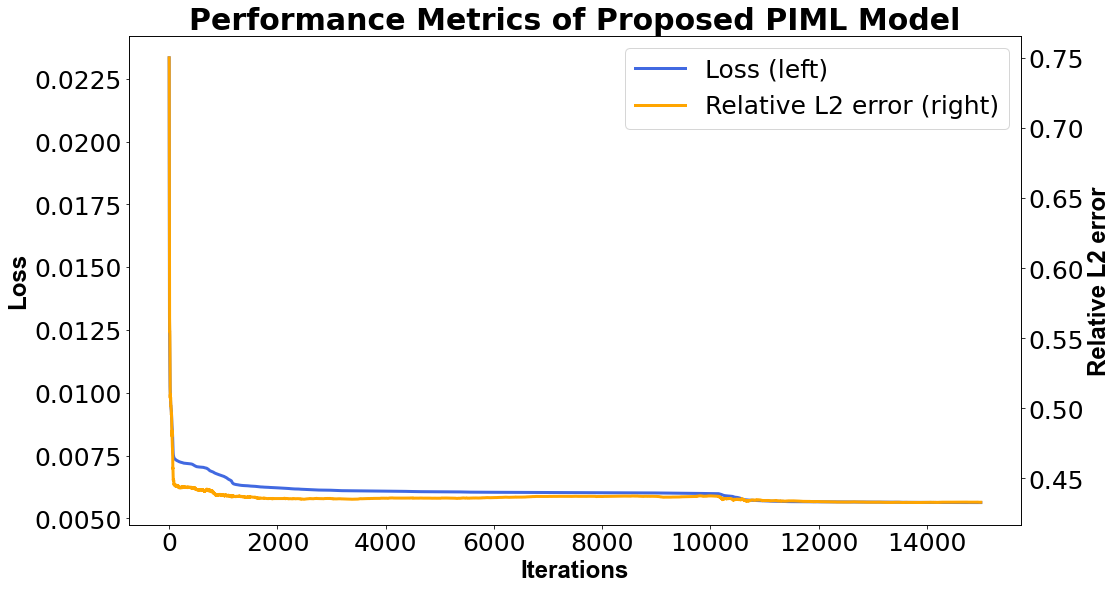

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.04569385851094667
MSE =  0.013983376672085277
RMSE =  0.11825132841573187
L2 relative error = 0.9958701751458904
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

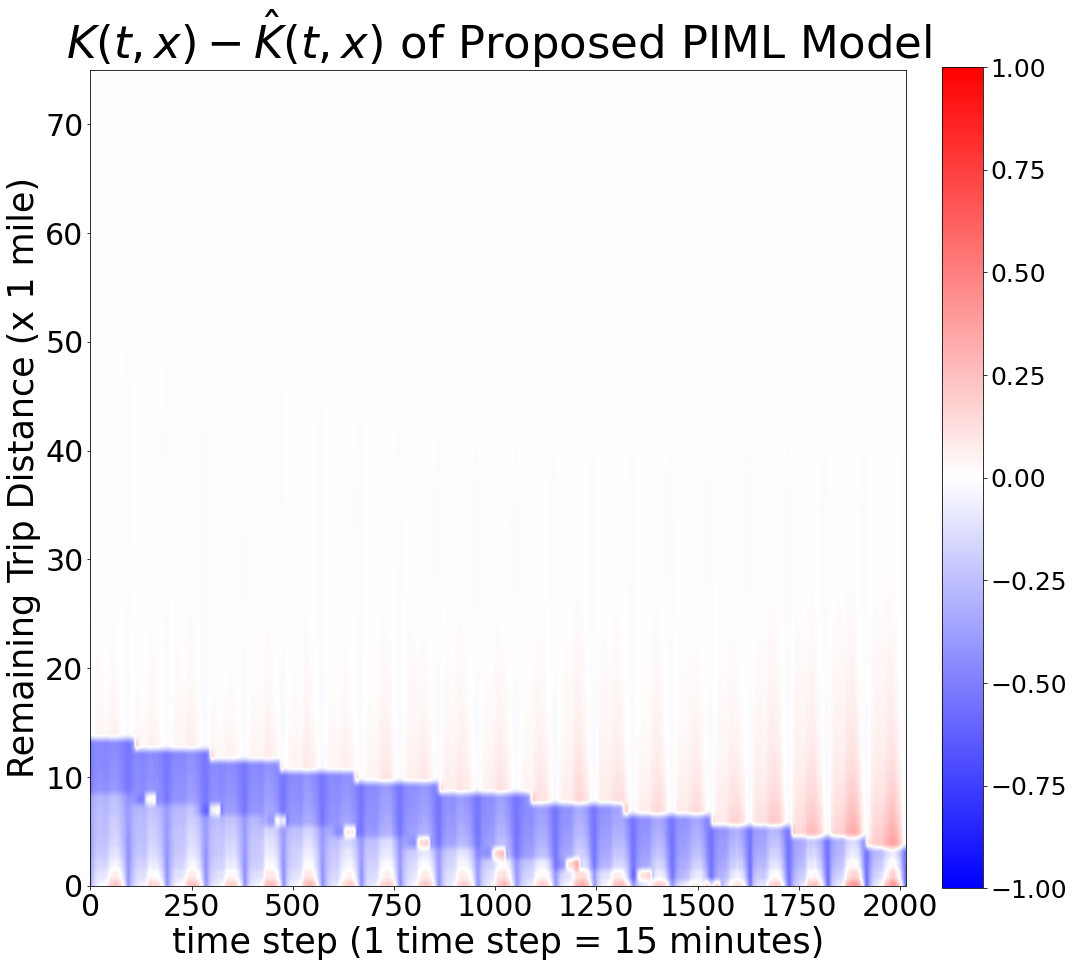

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

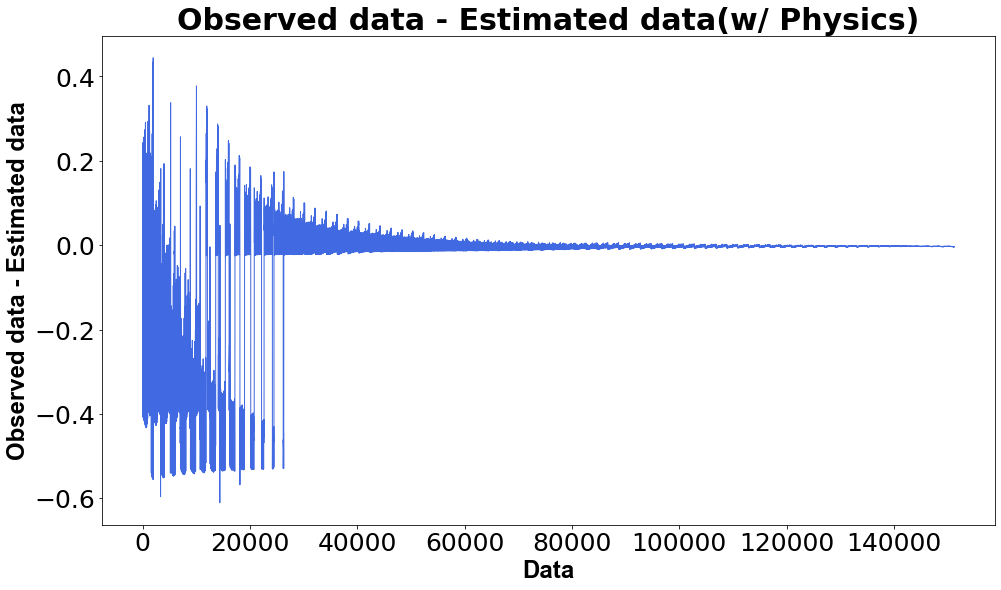

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

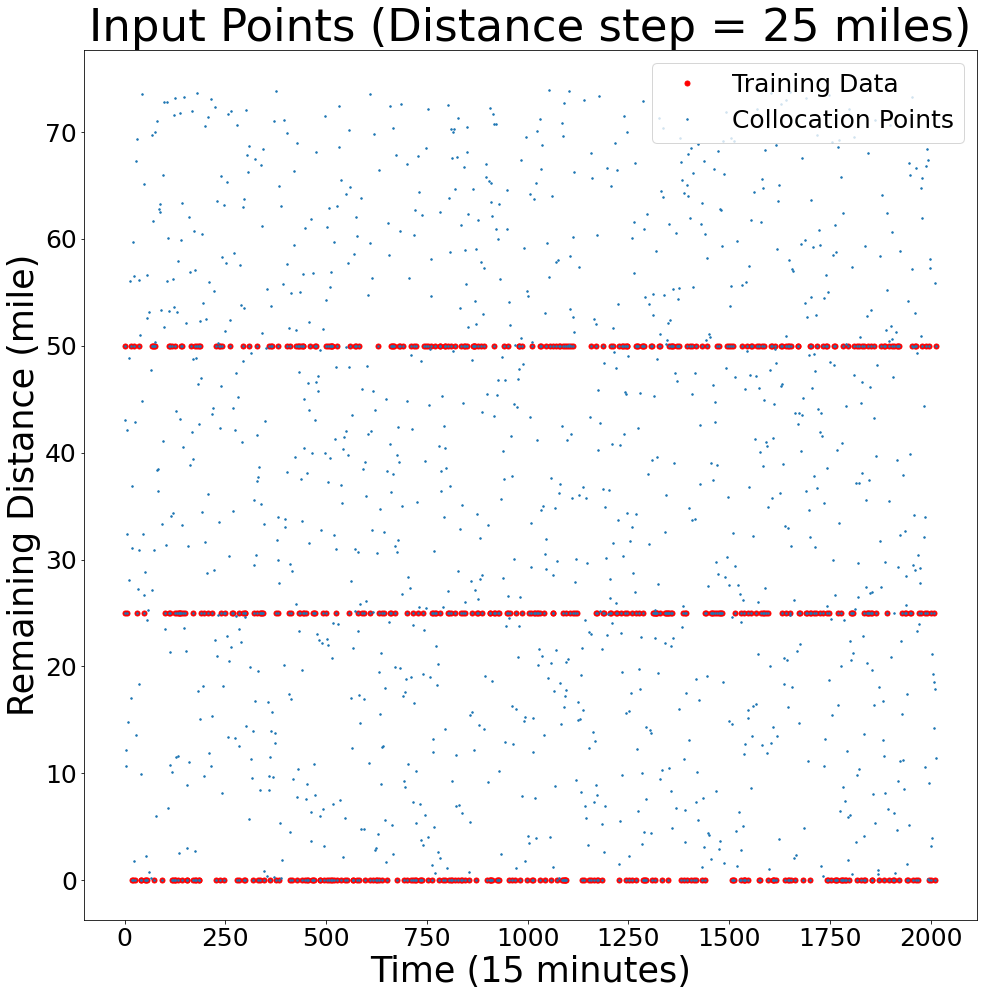

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 25 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

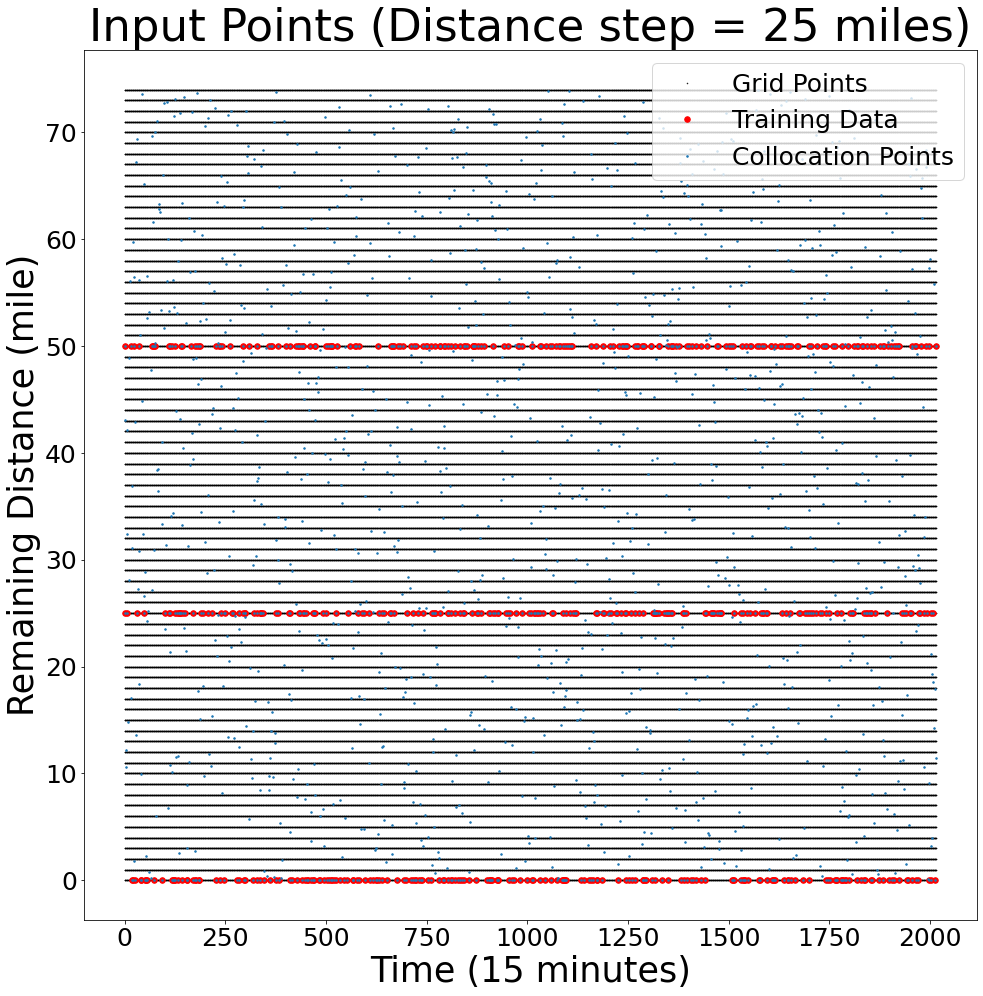

In [22]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 25 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


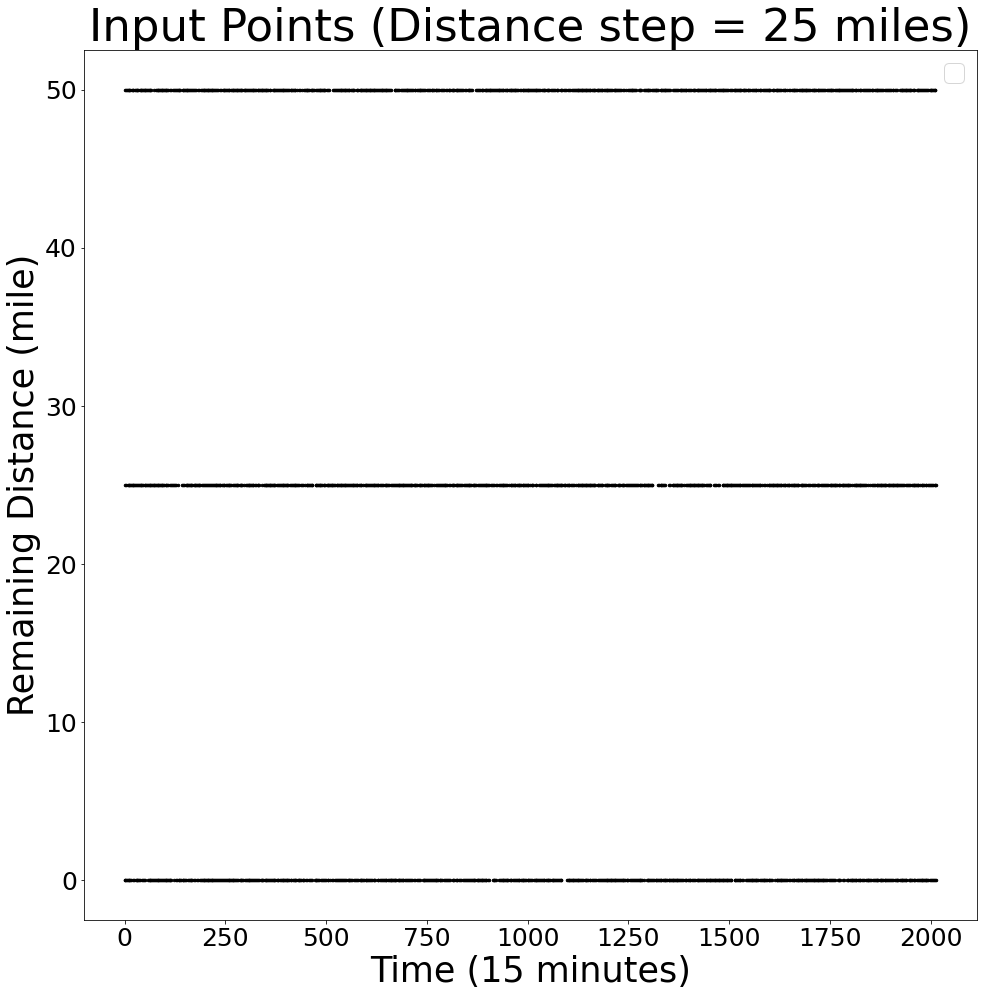

In [23]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_test[:,1]*multiplier_time, X_u_test[:,0]*multiplier_dist, 'o', color = 'black', markersize = 2.5)

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 25 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

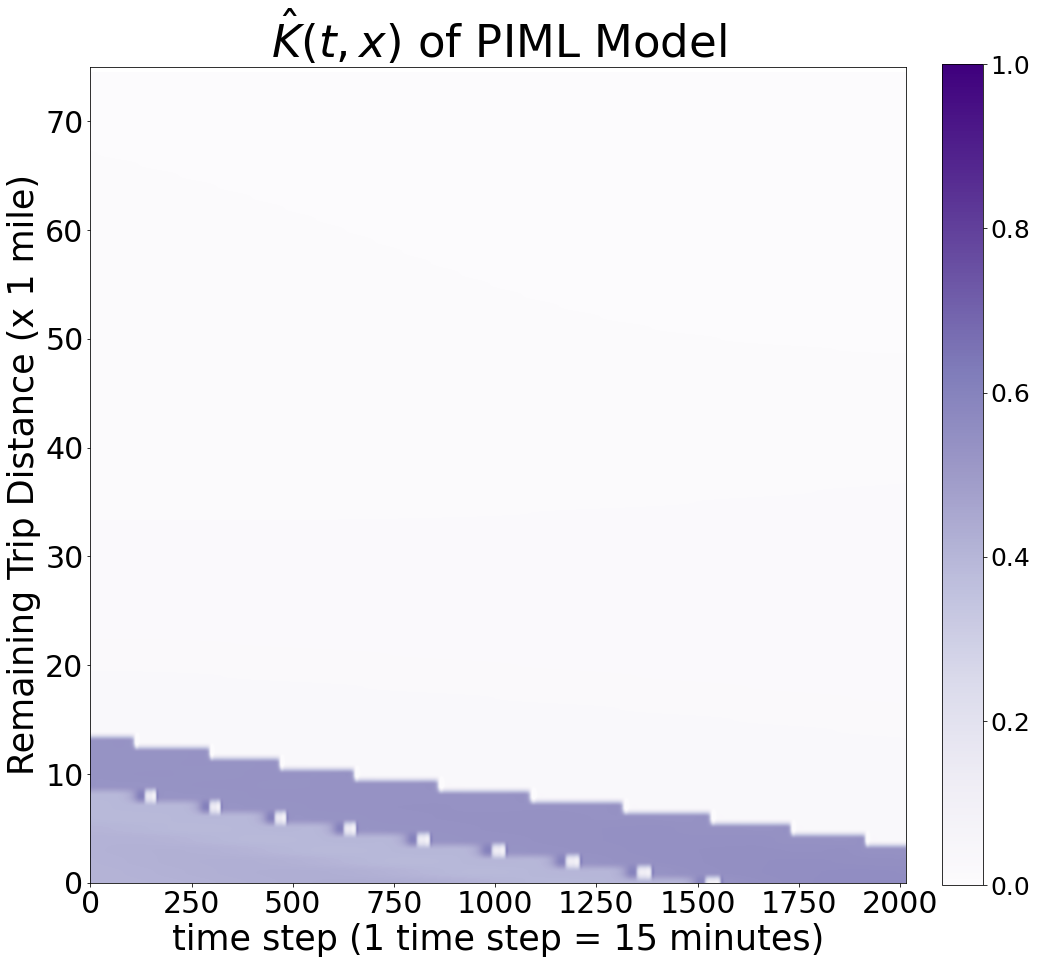

In [24]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

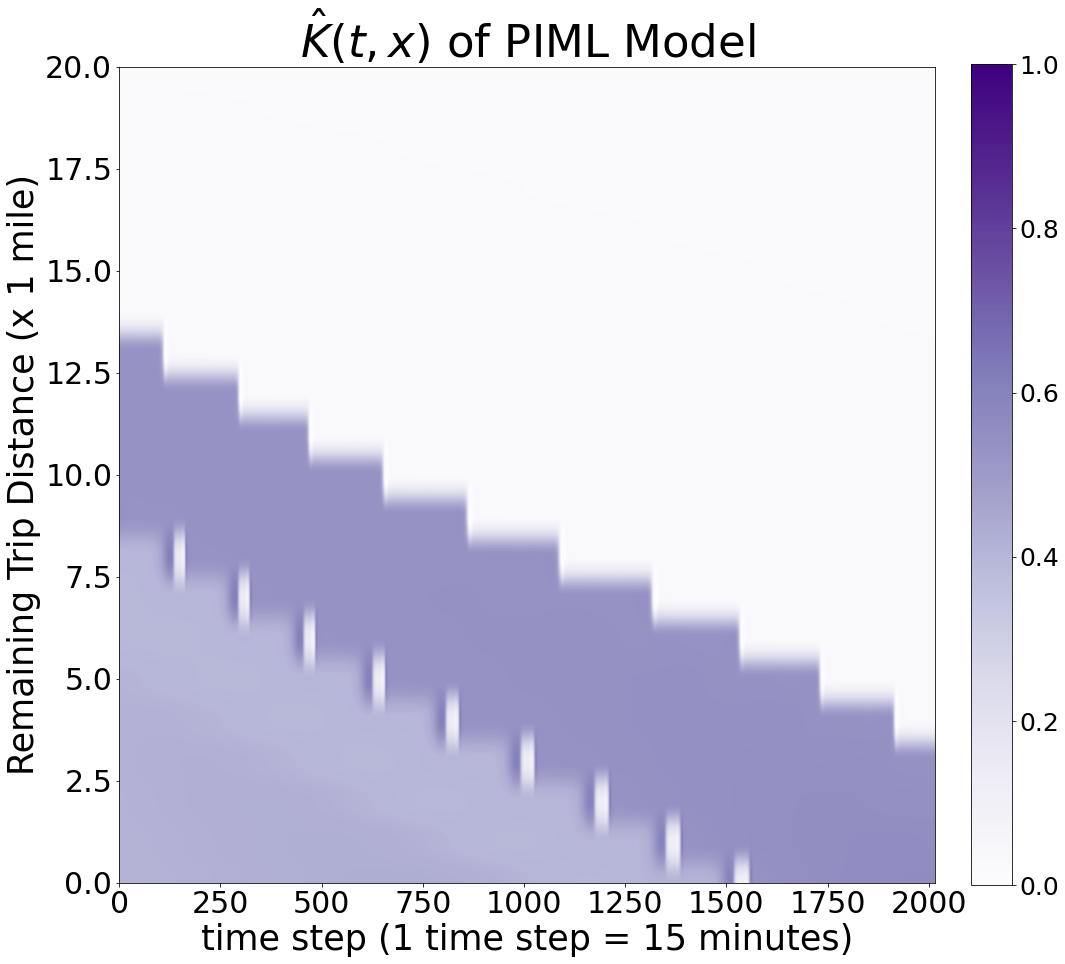

In [25]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

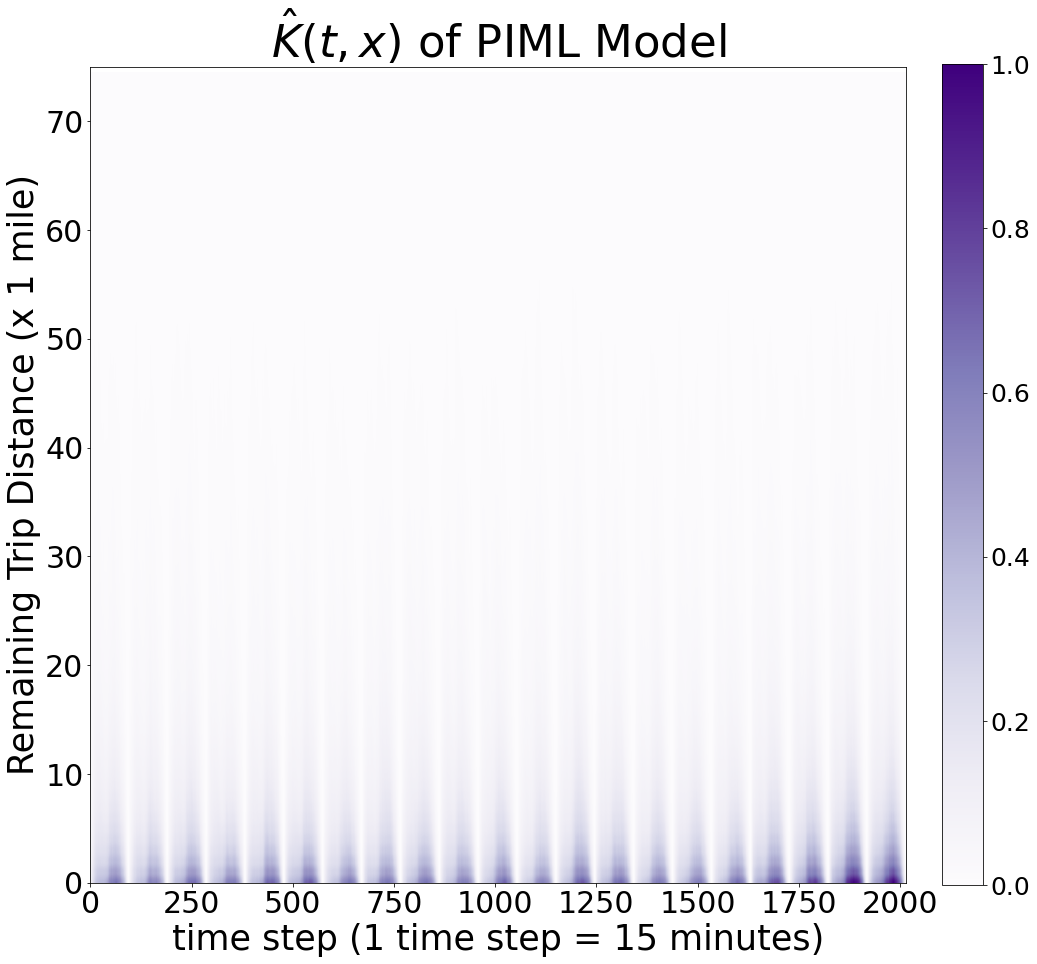

In [26]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

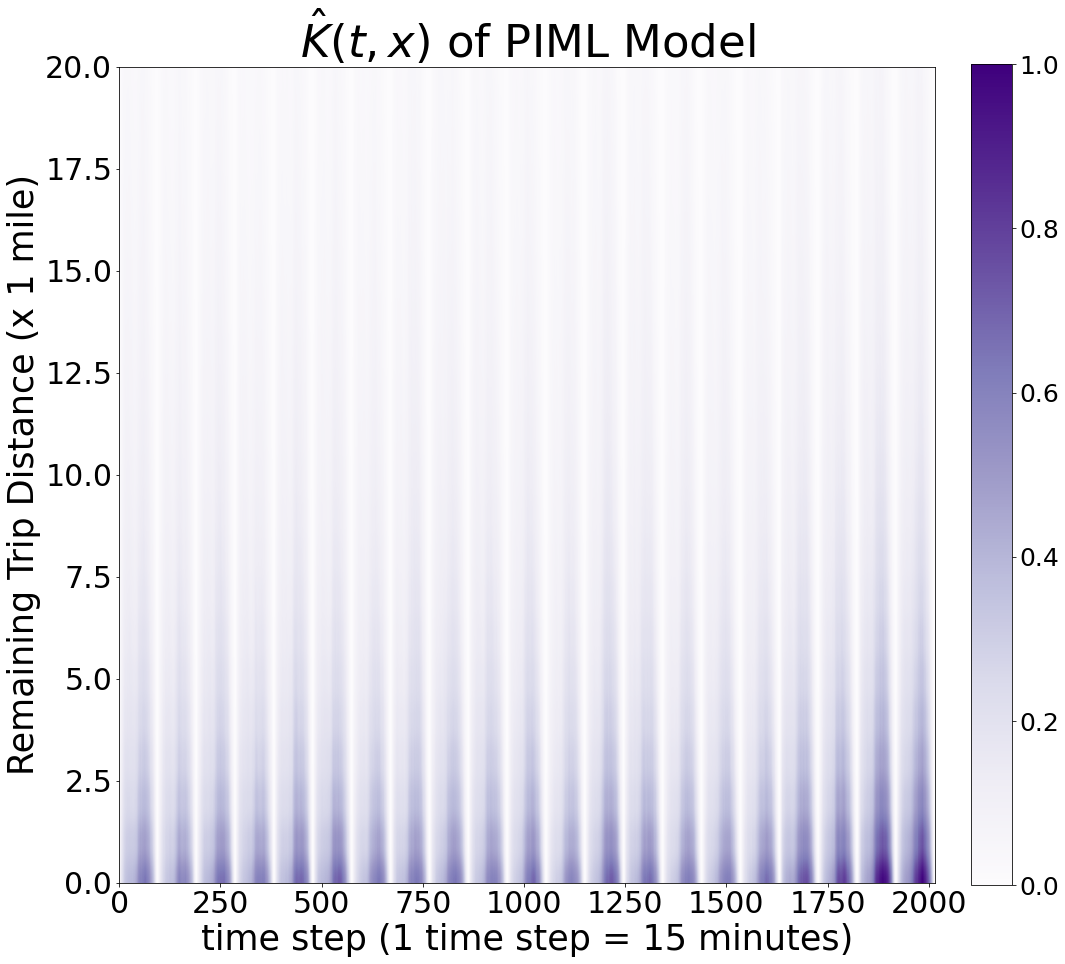

In [27]:
K_array = usol

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'Purples')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,20])
plt.clim(0, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)